# 1 Time Series 7-Day Forecasting with XGBoost<a id='1_time_series_7-day_forecasting_with_xbgoost'></a>

## 1.1 Contents<a id='1.1_contents'></a>
* [1 Time Series 7-Day Forecasting with XGBoost](#1_time_series_7-day_forecasting_with_xbgoost)
  * [1.1 Contents](#1.1_contents)  
  * [1.2 Import](#1.2_import)
  * [1.3 Function](#1.3_function)
      * [1.3.1 Functions: feature_list](#1.3.1_feature_list)
      * [1.3.2 Functions: split_sequences](#1.3.2_split_sequences)
      * [1.3.3 Functions: plot_test_set](#1.3.3_plot_test_set)
      * [1.3.4 Functions: split_sequence_features](#1.3.4_split_sequence_features)
  * [1.4 Load data](#1.4_load_data)  
  * [1.5 Preprocessing](#1.5_preprocessing)
      * [1.5.1 Preprocessing: get feature and target for model training and testing with cross-validation](#1.5.1_get_feature_target)
      * [1.5.2 Preprocessing: scale feature and target variables](#1.5.2_scale_feature_target)
  * [1.6 Train and test the XGBoost model](#1.6_train_test_XGBoost_model)
  * [1.7 Organize and evaluate model performance](#1.7_organize_evaludate_model)

## 1.2 Import<a id='1.2_import'></a>

In [1]:
from collections import defaultdict
from pathlib import Path
import os
import numpy as np
import numpy.matlib
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import pickle
from pathlib import Path
from xgboost import XGBRegressor, plot_tree
from deepdiff import DeepDiff
from datetime import date, timedelta
from isoweek import Week
import math
import warnings; warnings.simplefilter('ignore')

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
from sklearn.tree import export_graphviz

# Set Matplotlib defaults
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True, figsize=(11, 5))
plt.rc(
    "axes",
    labelweight="bold",
    labelsize=14,
    titleweight="bold",
    titlesize=16,
    titlepad=10,
)
plot_params = dict(
    color="0.75",
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25",
)

## 1.3 Function<a id='1.3_function'></a>

#### 1.3.1 Functions: feature_list <a id='1.3.1_feature_list'></a>

In [2]:
# organize features in each row into 1) static categorical, 2) temporal categorical, 3) temporal continuous
def feature_list(country_id, row): 
    # Static Categorical
    country = country_id #0 country id
    # Temporal Categorical (datetime variables)
    dt = row[0].to_pydatetime()
    year = dt.year #1
    month = dt.month #2
    day = dt.day #3
    week_of_year = dt.isocalendar()[1] #4
    day_of_week = row[1].dayow #5
    holiday = row[1].holiday #6 holiday
    # Temporal Continuous (mobility variables-this will be lagged for xgbr)
    # Temporal Continuous (weather variables)
    cloudcover = float(row[1].cloudcover) #13 weather; cloudcover
    tempC = float(row[1].tempC) #14 weather; temparature
    humidity = float(row[1].humidity) #15 weather; humidity
    precipMM = float(row[1].precipMM) #16 weather; precipitation
    # Temporal Continuous (vaccination-this will be lagged for xgbr)           
    return [country], \
[year, month, day, week_of_year, day_of_week, holiday], \
[cloudcover, tempC, humidity, precipMM] # Static Categorical, Temporal Categorical, Temporal Continuous

#### 1.3.2 Functions: split_sequences <a id='1.3.2_split_sequences'></a>

In [4]:
# get the input and output sequences from the entire time series
def split_sequences(sequences, timestamp, n_steps_in, n_steps_out): 
    timestamps = sequences.index
    df_time0 = timestamps[0]
    df_time_end = timestamps[-1]
    dt_steps_in = timedelta(days=n_steps_in)
    dt_steps_out = timedelta(days=n_steps_out-1)   
    dt_1 = timedelta(days=1)
    if (timestamp-dt_steps_in>=df_time0) & (timestamp+dt_steps_out<=df_time_end): # if within bounds
        # gather input and output parts of the pattern 
        seq_x = sequences[timestamp-dt_steps_in:timestamp-dt_1] # input sequence (e.g. previous 14 days) 
        seq_y = sequences[timestamp:timestamp+dt_steps_out] # output sequence (e.g. next 7 days including the current timestamp)
    return list(seq_x), list(seq_y)

#### 1.3.3 Functions: plot_test_set <a id='1.3.3_plot_test_set'></a>

In [357]:
def plot_test_set(rez_dict, dict_country, save_name, n_steps_out=7):
    countries = sorted(set(rez_dict['country']))
    # plot for each of the 7-day forecast
    for country in countries:
        fig, ax = plt.subplots(n_steps_out, 1, figsize=(12, 36))
        fig.subplots_adjust(wspace=0.5, hspace=0.7)
        
        country_idx = [cc==country for cc in rez_dict['country']]
        timestamps = [i for i,v in zip(rez_dict['timestamp'],country_idx) if v]
        
        holidays = np.array(dict_country[country].loc[timestamps, 'holiday']==1) # holidays
        sundays = np.array(dict_country[country].loc[timestamps, 'dayow']==6) # Sundays
        holi_sun = np.logical_or(holidays, sundays)
        holiday_timestamps = [date.strftime(i, '%b-%d') for i,v in zip(rez_dict['timestamp'],holi_sun) if v]
        
        y_actual = rez_dict['y'][country_idx,:]
        y_pred = rez_dict['y_pred'][country_idx,:]
        
        for i in range(n_steps_out):
            ts_td = [t+timedelta(days=i) for t in timestamps]
            ts = list(map(lambda x:date.strftime(x,'%b-%d'),ts_td))           
            ax[i].plot(ts, y_actual[:,i], 'o-')
            ax[i].plot(ts, y_pred[:,i], 'o-')
            ax[i].set_xlabel('Date', fontsize=10, fontweight='bold')
            ax[i].set_xlim(ts[0], ts[-1])
            ax[i].set_ylabel('Cases per million', fontsize=10, fontweight='bold')          
            ax[i].set_title(country + '_step_#' + str(i), fontweight='bold', fontsize=14)
            ax[i].legend(['y_actual','y_pred'], prop=dict(weight='bold',size=8))
            for tick in ax[i].get_xticklabels():
                tick.set_rotation(45)
            ax[i].tick_params(axis='x', labelsize=8)
            for holi in holiday_timestamps:
                ax[i].axvspan(holi, holi, color='red', alpha=0.3, linewidth=2)
        # figure save
        fig.savefig(os.path.join('/Users/parkj/Documents/pyDat/dataSet/covid19_figures', \
                                 country+'_'+save_name+'_xgbr_7d.pdf'), tranparent=True)

#### 1.3.4 Functions: split_sequence_features <a id='1.3.4_split_sequence_features'></a>

In [7]:
def split_sequence_features(df_country, ts_curr): 
    f_rtrc, _ = split_sequences(df_country['rtrc'], ts_curr, n_steps_in=14, n_steps_out=0)  
    f_grph, _ = split_sequences(df_country['grph'], ts_curr, n_steps_in=14, n_steps_out=0)
    f_prks, _ = split_sequences(df_country['prks'], ts_curr, n_steps_in=14, n_steps_out=0)   
    f_tran, _ = split_sequences(df_country['tran'], ts_curr, n_steps_in=14, n_steps_out=0)   
    f_work, _ = split_sequences(df_country['work'], ts_curr, n_steps_in=14, n_steps_out=0)
    f_resi, _ = split_sequences(df_country['resi'], ts_curr, n_steps_in=14, n_steps_out=0)
    f_vac, _ = split_sequences(df_country['vac'], ts_curr, n_steps_in=14, n_steps_out=0)
    f_case, t_case = split_sequences(df_country['case_mil'], ts_curr, n_steps_in=14, n_steps_out=7)    
    return f_rtrc, f_grph, f_prks, f_tran, f_work, f_resi, f_vac, f_case, t_case

#### 1.3.9 Functions: rmse_y_y_pred <a id='1.3.9_rmse_y_y_pred'></a>

In [304]:
def rmse_y_y_pred(rez_dict, n_steps_out):
    rmse_dict = {}
    countries = sorted(set(rez_dict['country']))
    for country in countries:
        country_idx = [cc==country for cc in rez_dict['country']]
        country_rmse = []
        for d in range(n_steps_out):
            country_rmse.append(mean_squared_error(rez_dict['y'][country_idx,d], rez_dict['y_pred'][country_idx,d], squared=False))
        rmse_dict[country] = country_rmse
    return rmse_dict 

## 1.4 Load data<a id='1.4_load_data'></a>

In [11]:
# load data from pickle file
filePath_pickle = Path('/Users/parkj/Documents/pyDat/dataSet/covid_country_data.pickle')
with open(filePath_pickle, 'rb') as f:
    dict_country = pickle.load(f)
# countries = ['AR', 'AT', 'AU', 'BE', 'CA', 'DE', 'DK', 'FI', 'FR', 'GB', 'ID', 'IE', 'IL', 'IN', 'IT', 'JP', 'KR', 'MX', 'NL', 'NO', 'RU', 'SG', 'US']

## 1.5 Preprocessing <a id='1.5_Preprocessing'></a>

#### 1.5.1 Preprocessing: get feature and target for model training and testing with cross-validation <a id='1.5.1_get_feature_target'></a>

In [12]:
train_timestamp = []
train_country = []
train_stat_cat = []
train_temp_cat = []
train_temp_con = []
train_f_rtrc = []
train_f_grph = []
train_f_prks = []
train_f_tran = []
train_f_work = []
train_f_resi = []
train_f_vac = []
train_f_case = []
train_y_unscaled = []

test_timestamp = []
test_country = []
test_stat_cat = []
test_temp_cat = []
test_temp_con = []
test_f_rtrc = []
test_f_grph = []
test_f_prks = []
test_f_tran = []
test_f_work = []
test_f_resi = []
test_f_vac = []
test_f_case = []
test_y_unscaled = []

n_test = 21 # days
dt_test = timedelta(days=n_test-1)
n_steps_in = 14 # days (# previous cases)
dt_steps_in = timedelta(days=n_steps_in)
n_steps_out = 7 # days (# future cases to be predicted)
dt_steps_out = timedelta(days=n_steps_out-1)

for i, country_key in enumerate(dict_country.keys()):
    case_detection = 0
    df_country = dict_country[country_key]
    df_country.fillna(method='ffill',inplace=True) # forward fill NaNs
    df_time0 = df_country.index[0] # the first day of the data
    df_time_end = df_country.index[-1] # the last day of the data
    # split the df into train and test sets
    test_time0 = df_country.index[-1]-dt_test # the first date of test set 
    train_ind = df_country.index < test_time0 # training index
    # feature_list train 
    df_country_train = df_country.loc[train_ind] # train df
    for row in df_country_train.iterrows():
        ts_curr = row[0] 
        # case_mil lagging
        if (ts_curr-dt_steps_in>=df_time0) & (ts_curr+dt_steps_out<=df_time_end):
            # get feature and target variables
            f_rtrc, f_grph, f_prks, f_tran, f_work, f_resi, f_vac, f_case, t_case = split_sequence_features(df_country, ts_curr)     
            if (case_detection == 0) & (sum(f_case)>0): # to exclude days before 1st case detection
                case_detection = 1
            if case_detection == 1:
                fl_stat_cat, fl_temp_cat, fl_temp_con = feature_list(i, row) # get static categorical, temporal categorical, temporal continuous variables separately 
                # train data X (for embeddings)
                train_country.append(row[1].country_region_code)
                train_timestamp.append(ts_curr) # timestamps
                train_stat_cat.append(fl_stat_cat) # static categorical 
                train_temp_cat.append(fl_temp_cat) # temporal categorical 
                train_temp_con.append(fl_temp_con) # temporal continuous
                # train data X (for xgbr)
                train_f_rtrc.append(f_rtrc)
                train_f_grph.append(f_grph)
                train_f_prks.append(f_prks)
                train_f_tran.append(f_tran)
                train_f_work.append(f_work)
                train_f_resi.append(f_resi)
                train_f_vac.append(f_vac)
                train_f_case.append(f_case) # case_mil previous days to be used as features
                # train data y
                train_y_unscaled.append(t_case) # case_mil current & future days to be predicted
    # feature list test
    df_country_test = df_country.loc[~train_ind] # test df
    # feature list test 
    for row in df_country_test.iterrows():
        ts_curr = row[0]
        # case_mil lagging
        if (ts_curr-dt_steps_in>=df_time0) & (ts_curr+dt_steps_out<=df_time_end):        
            # get feature and target variables
            f_rtrc, f_grph, f_prks, f_tran, f_work, f_resi, f_vac, f_case, t_case = split_sequence_features(df_country, ts_curr)   
            fl_stat_cat, fl_temp_cat, fl_temp_con = feature_list(i, row) # get static categorical, temporal categorical, temporal continuous variables separately
            # test data X (for embeddings)
            test_country.append(row[1].country_region_code)
            test_timestamp.append(ts_curr)
            test_stat_cat.append(fl_stat_cat) # static categorical 
            test_temp_cat.append(fl_temp_cat) # temporal categorical 
            test_temp_con.append(fl_temp_con) # temporal continuous
            # test data X (for xgbr)
            test_f_rtrc.append(f_rtrc)
            test_f_grph.append(f_grph)
            test_f_prks.append(f_prks)
            test_f_tran.append(f_tran)
            test_f_work.append(f_work)
            test_f_resi.append(f_resi)
            test_f_vac.append(f_vac)      
            test_f_case.append(f_case) # case_mil previous days to be used as features
            # train data y
            test_y_unscaled.append(t_case) # case_mil current & future days to be predicted

#### 1.5.2 Preprocessing: scale or embed feature and target variables <a id='1.5.2_scale_feature_target'></a>

In [165]:
def matrix_scaler_over_all_columns(input_list, scaler_):
    concat_1d = []
    for m in input_list:
        concat_1d.append(np.reshape(m, (np.shape(m)[0]*np.shape(m)[1],1)))
    concat_1d_array = np.concatenate(concat_1d, axis=0)
    
    output_list = []
    for m in input_list:
        repmat = np.matlib.repmat(concat_1d_array, 1, np.shape(m)[1])
        #scaler_ = StandardScaler()
        scaler_.fit(repmat)
        output_list.append(scaler_.transform(m))       
    return output_list, scaler_

In [166]:
def matrix_scaler_each_column(input_list, scaler_):
    concat = np.concatenate(input_list, axis=0)
    scaler_.fit(concat)
    output_list = []
    for m in input_list:
        output_list.append(scaler_.transform(m))       
    return output_list

In [167]:
# static categorical (country ID) 
train_stat_cat = np.array(train_stat_cat)
test_stat_cat = np.array(test_stat_cat)
# temporal categorical (date info)
train_temp_cat = np.array(train_temp_cat)
test_temp_cat = np.array(test_temp_cat)
# scale temporal continuous (weather info)
temp_con_scaled = matrix_scaler_each_column([train_temp_con, test_temp_con], MinMaxScaler())
train_temp_con_scaled = temp_con_scaled[0]
test_temp_con_scaled = temp_con_scaled[1]
# scale lagged temporal continuous (for xgbr)
# rtrc
rtrc_scaled, _ = matrix_scaler_over_all_columns([train_f_rtrc, test_f_rtrc], MinMaxScaler())
train_rtrc_scaled = rtrc_scaled[0]
test_rtrc_scaled = rtrc_scaled[1]
# grph
grph_scaled, _ = matrix_scaler_over_all_columns([train_f_grph, test_f_grph], MinMaxScaler())
train_grph_scaled = grph_scaled[0]
test_grph_scaled = grph_scaled[1]
# prks
prks_scaled, _ = matrix_scaler_over_all_columns([train_f_prks, test_f_prks], MinMaxScaler())
train_prks_scaled = prks_scaled[0]
test_prks_scaled = prks_scaled[1]
# tran
tran_scaled, _ = matrix_scaler_over_all_columns([train_f_tran, test_f_tran], MinMaxScaler())
train_tran_scaled = tran_scaled[0]
test_tran_scaled = tran_scaled[1]
# work
work_scaled, _ = matrix_scaler_over_all_columns([train_f_work, test_f_work], MinMaxScaler())
train_work_scaled = work_scaled[0]
test_work_scaled = work_scaled[1]
# resi
resi_scaled, _ = matrix_scaler_over_all_columns([train_f_resi, test_f_resi], MinMaxScaler())
train_resi_scaled = resi_scaled[0]
test_resi_scaled = resi_scaled[1]
# vac
vac_scaled, _ = matrix_scaler_over_all_columns([train_f_vac, test_f_vac], MinMaxScaler())
train_vac_scaled = vac_scaled[0]
test_vac_scaled = vac_scaled[1]
# case
case_scaled, scaler_y = matrix_scaler_over_all_columns([train_f_case, test_f_case, train_y_unscaled, test_y_unscaled], StandardScaler())
train_f_case_scaled = case_scaled[0]
test_f_case_scaled = case_scaled[1]
train_y = case_scaled[2]
test_y = case_scaled[3]

# concatenate features to get X
train_X = np.concatenate((train_stat_cat, train_temp_cat, train_temp_con_scaled, \
                          train_rtrc_scaled, train_grph_scaled, train_prks_scaled, train_tran_scaled, \
                          train_work_scaled, train_resi_scaled, train_vac_scaled, train_f_case_scaled), axis=1)

test_X = np.concatenate((test_stat_cat, test_temp_cat, test_temp_con_scaled, \
                         test_rtrc_scaled, test_grph_scaled, test_prks_scaled, test_tran_scaled, \
                         test_work_scaled, test_resi_scaled, test_vac_scaled, test_f_case_scaled), axis=1)
print("Number of train datapoints: ", len(train_y))
print("Number of test datapoints: ", len(test_y))

Number of train datapoints:  12541
Number of test datapoints:  345


## 1.6 Train and test the XGBoost model <a id='1.6_train_test_XGBoost_model'></a>

In [65]:
# get the cross-validation folds for train and validation sets  
train_folds = []
validation_folds = []
# get the timestamps for train and validation folds
sorted_train_timestamp = sorted((set(train_timestamp))) # unique timestamps in the train set
tscv = TimeSeriesSplit(n_splits=5, test_size=21) # splitting train and validations sets for cross validation
for train_idx, validation_idx in tscv.split(sorted_train_timestamp): # get train and validation sets
    # print("TRAIN:", train_idx, "VALIDATION:", validation_idx)
    train_folds.append([sorted_train_timestamp[i] for i in train_idx]) # folds in train set
    validation_folds.append([sorted_train_timestamp[i] for i in validation_idx]) # folds in validation set

train_preds = []
train_idx_fold = [] 
val_preds = []
val_idx_fold = []
test_preds = []

xgbr_params = [100, 500, 1000, 2000, 3000] # the list of parameters (n_estimators) for a grid search 

train_preds = []
val_preds = []
test_preds = []

# train and test the model with cross validation
for fold in range(len(train_folds)): # iterate cross-validation folds
    fold_idx_train = [ts in train_folds[fold] for ts in train_timestamp]
    train_idx_fold.append(fold_idx_train)
    fold_idx_val = [ts in validation_folds[fold] for ts in train_timestamp]
    val_idx_fold.append(fold_idx_val)
    X_train_f, X_val_f = train_X[fold_idx_train,:], train_X[fold_idx_val,:] # X_train for the current fold
    y_train_f, y_val_f = train_y[fold_idx_train,:], train_y[fold_idx_val,:] # y_train for the current fold
    
    y_train_pred_f = np.empty((y_train_f.shape[0], n_steps_out, len(xgbr_params))) # the 3rd dimension for grid search of an optimal parameter (n_estimators)
    y_val_pred_f = np.empty((y_val_f.shape[0], n_steps_out, len(xgbr_params)))
    y_test_pred_f = np.empty((test_X.shape[0], n_steps_out, len(xgbr_params))) 
    for day in range(n_steps_out):
        for i, param in enumerate(xgbr_params):
            # XGBoost regression model fit
            xgbr = XGBRegressor(objective='reg:squarederror', n_estimators=param)
            xgbr.fit(X_train_f, y_train_f[:,day])
            
            y_train_pred_f[:,day, i] = xgbr.predict(X_train_f)
            y_val_pred_f[:,day, i] = xgbr.predict(X_val_f)
            y_test_pred_f[:,day, i] = xgbr.predict(test_X)
            
            print('Completed iteration for param #{0:d} of step #{1:d} in fold #{2:d}'.format(i, day, fold))
            
    train_preds.append(y_train_pred_f)
    val_preds.append(y_val_pred_f)
    test_preds.append(y_test_pred_f)

#### 1.6.1 Train and test the XGBoost model: pick the best parameter (n_estimators) <a id='1.6.1_train_test_xgboost_model_best_parameter'></a>

#### 1.6.1.1 Train and test the XGBoost model: pick the best parameter over the validation set (n_estimators) <a id='1.6.1.1_train_test_xgboost_model_best_parameter_validation'></a>

In [249]:
validation_mae = np.empty((len(val_idx_fold), len(xgbr_params)))
validation_mae[:] = np.NaN

for f, val_idx in enumerate(val_idx_fold): # folds
    # average val_preds across folds to get val_y_pred
    val_y_fold = scaler_y.inverse_transform(train_y[val_idx,:])
    for p in range(len(xgbr_params)):
        val_y_pred_param = scaler_y.inverse_transform(val_preds[f][:,:,p])
        validation_mae[f,p] = mean_squared_error(val_y_fold, val_y_pred_param, squared=False)

mean_validation_mae = np.mean(validation_mae, axis=0) # mean mae on the validation set as a function of the number of estimators in the XGBregressor

#### 1.6.1.2 Train and test the XGBoost model: pick the best parameter over the test set (n_estimators) <a id='1.6.1.2_train_test_xgboost_model_best_parameter_validation_test'></a>

In [335]:
test_mae = np.empty((len(train_folds), len(xgbr_params)))
test_mae[:] = np.NaN

test_y_inv_scale = scaler_y.inverse_transform(test_y)
for f in range(len(train_folds)): # folds
    for p in range(len(xgbr_params)): 
        test_y_pred_param = scaler_y.inverse_transform(test_preds[f][:,:,p])
        test_mae[f,p] = mean_squared_error(test_y_inv_scale, test_y_pred_param, squared=False)

mean_test_mae = np.mean(test_mae, axis=0) # mean mae on the test set as a function of the number of estimators in the XGBregressor

## 1.7 Organize and evaluate model performance <a id='1.7_organize_evaludate_model'></a>

#### 1.7.1 Organize and evaluate model performance: train set <a id='1.7.1_organize_evaludate_model_train'></a>

In [ ]:
# average train_preds across folds to get train_y_pred
train_y_pred_fold = np.empty((len(train_idx_fold[0]), n_steps_out, len(train_preds)))
train_y_pred_fold[:]=np.NaN
for i, train_idx in enumerate(train_idx_fold): 
    train_y_pred_fold[train_idx,:,i] = train_preds[i][:,:,0] # note that the n_estimators=100 led to minimal error, so use it
train_y_pred = np.nanmean(train_y_pred_fold, axis=2)

rez_xgbr_7d_train = {}
train_set_idx = np.isnan(train_y_pred).sum(axis=1)==0
rez_xgbr_7d_train['timestamp'] = [train_timestamp[i] for i, logic in enumerate(train_set_idx) if logic ==True]
rez_xgbr_7d_train['country'] = [train_country[i] for i, logic in enumerate(train_set_idx) if logic ==True]
rez_xgbr_7d_train['X'] = train_X[train_set_idx,:] # note that variables are scaled and preprocessed for embedding 
rez_xgbr_7d_train['y'] = scaler_y.inverse_transform(train_y)[train_set_idx,:] # back to the original unit (cases per million)
rez_xgbr_7d_train['y_pred'] = scaler_y.inverse_transform(train_y_pred)[train_set_idx,:] 
rez_xgbr_7d_train['rmse'] = rmse_y_y_pred(rez_xgbr_7d_train, n_steps_out)

#### 1.7.2 Organize and evaluate model performance: validation set <a id='1.7.2_organize_evaludate_model_validation'></a>

In [ ]:
# average val_preds across folds to get val_y_pred
val_y_pred_fold = np.empty((len(train_idx_fold[0]), n_steps_out, len(val_preds)))
val_y_pred_fold[:] = np.NaN
for i, val_idx in enumerate(val_idx_fold): 
    val_y_pred_fold[val_idx,:,i] = val_preds[i][:,:,0]
val_y_pred = np.nanmean(val_y_pred_fold, axis=2)

rez_xgbr_7d_val = {}
val_set_idx = np.isnan(val_y_pred).sum(axis=1)==0
rez_xgbr_7d_val['timestamp'] = [train_timestamp[i] for i, logic in enumerate(val_set_idx) if logic ==True]
rez_xgbr_7d_val['country'] = [train_country[i] for i, logic in enumerate(val_set_idx) if logic ==True]
rez_xgbr_7d_val['X'] = train_X[val_set_idx,:] # note that variables are scaled and preprocessed for embedding 
rez_xgbr_7d_val['y'] = scaler_y.inverse_transform(train_y)[val_set_idx,:] # back to the original unit (cases per million)
rez_xgbr_7d_val['y_pred'] = scaler_y.inverse_transform(val_y_pred)[val_set_idx,:] 
rez_xgbr_7d_val['rmse'] = rmse_y_y_pred(rez_xgbr_7d_val, n_steps_out)

#### 1.7.3 Organize and evaluate model performance: test set <a id='1.7.3_organize_evaludate_model_test'></a>

In [355]:
test_y_pred_fold = np.empty((test_y.shape[0], n_steps_out, len(test_preds)))
test_y_pred_fold[:] = np.NaN

for i in range(len(test_preds)): 
    test_y_pred_fold[:,:,i] = test_preds[i][:,:,0] 
test_y_pred = np.nanmean(test_y_pred_fold, axis=2)
    
rez_xgbr_7d_test = {}
rez_xgbr_7d_test['timestamp'] = test_timestamp
rez_xgbr_7d_test['country'] = test_country
rez_xgbr_7d_test['X'] = test_X # note that variables are scaled and preprocessed for embedding 
rez_xgbr_7d_test['y'] = scaler_y.inverse_transform(test_y)
rez_xgbr_7d_test['y_pred'] = scaler_y.inverse_transform(test_y_pred)
rez_xgbr_7d_test['rmse'] = rmse_y_y_pred(rez_xgbr_7d_test, n_steps_out)

#### 1.7.4 Organize and evaluate model performance: save data<a id='1.7.4_organize_evaludate_model_save'></a>

In [360]:
rez_xgbr_7d = {'train':rez_xgbr_7d_train, 'validation':rez_xgbr_7d_val, 'test':rez_xgbr_7d_test}

filePath_pickle = Path('/Users/parkj/Documents/pyDat/pyDatCode/covid19/covid19_xgbr_7d_with_lagging.pickle')
with open(filePath_pickle, 'wb') as f:
     pickle.dump(rez_xgbr_7d, f)

#### 1.7.5 Organize and evaluate model performance: plot <a id='1.7.5_organize_evaludate_model_plot'></a>

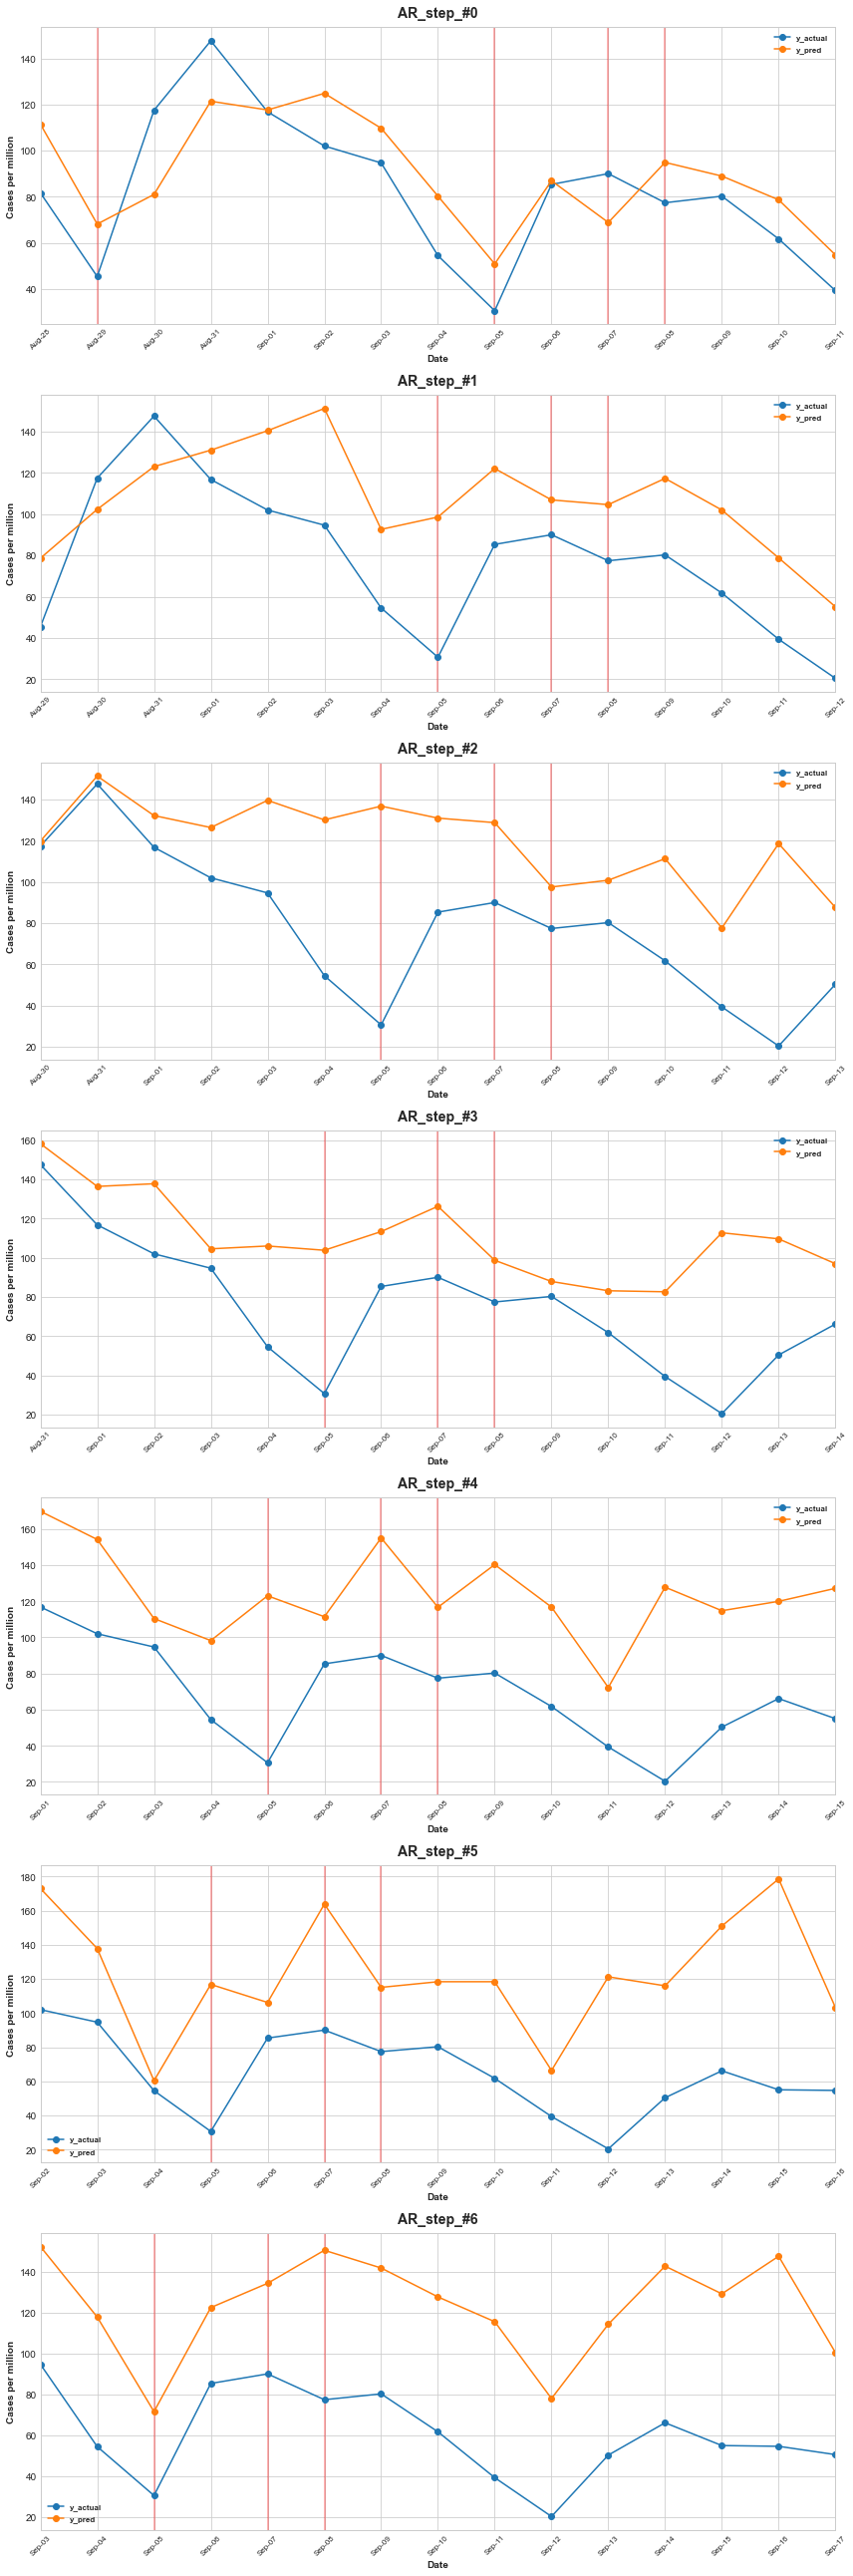

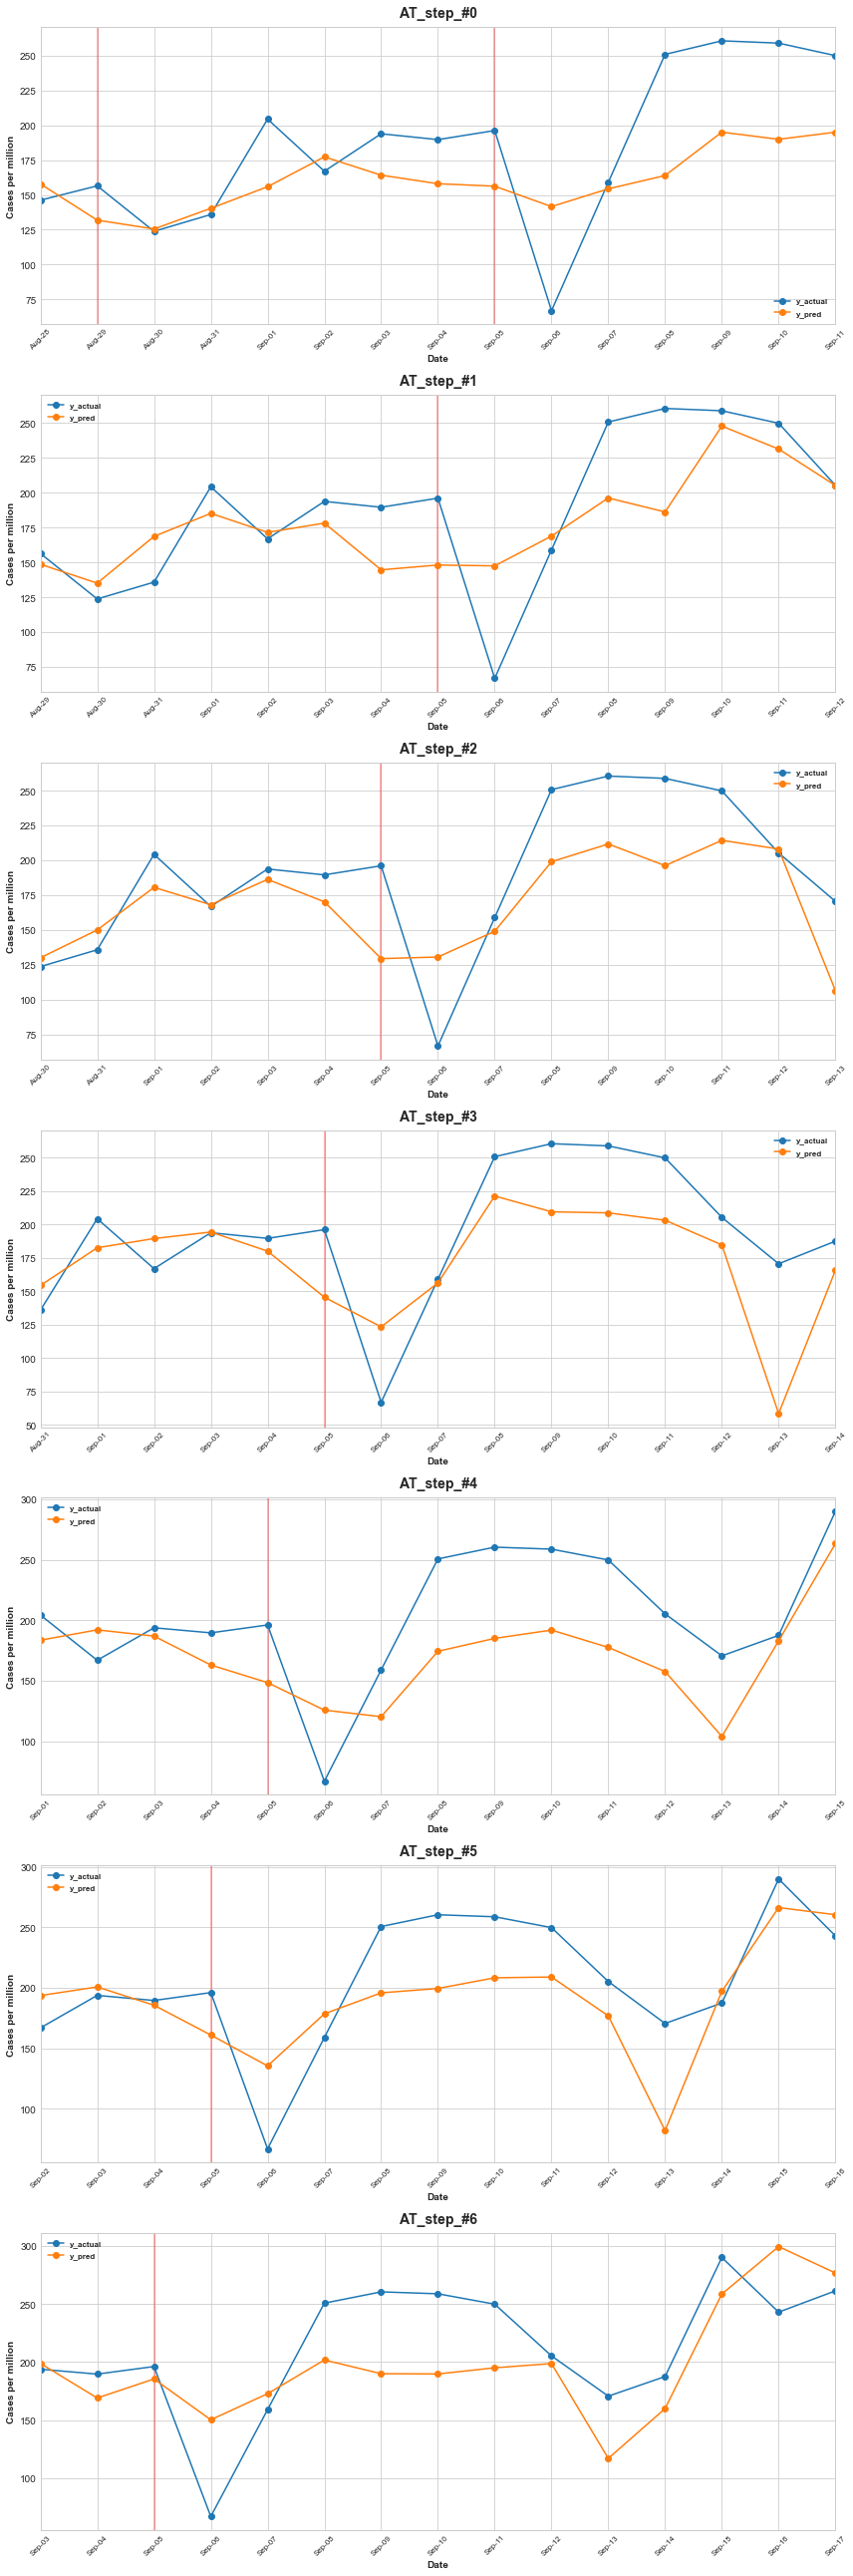

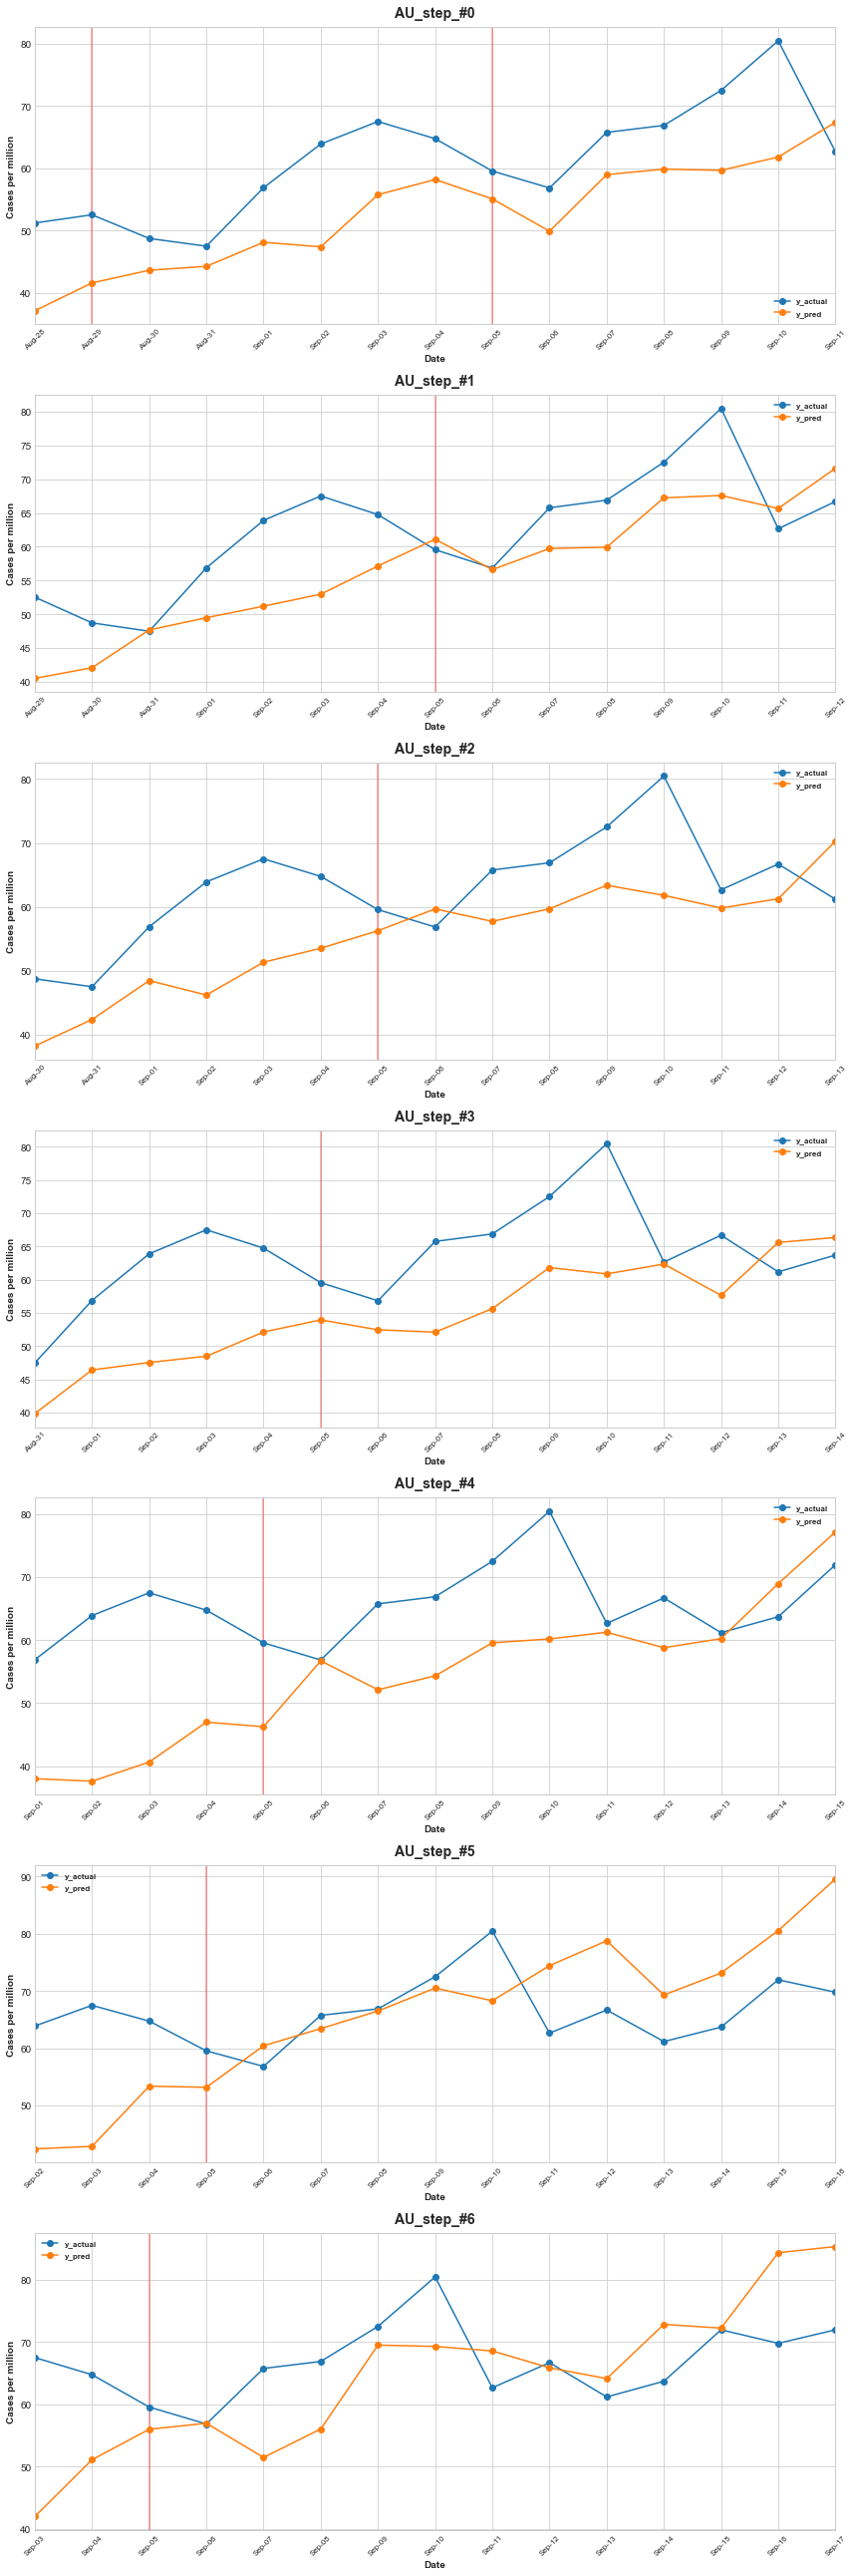

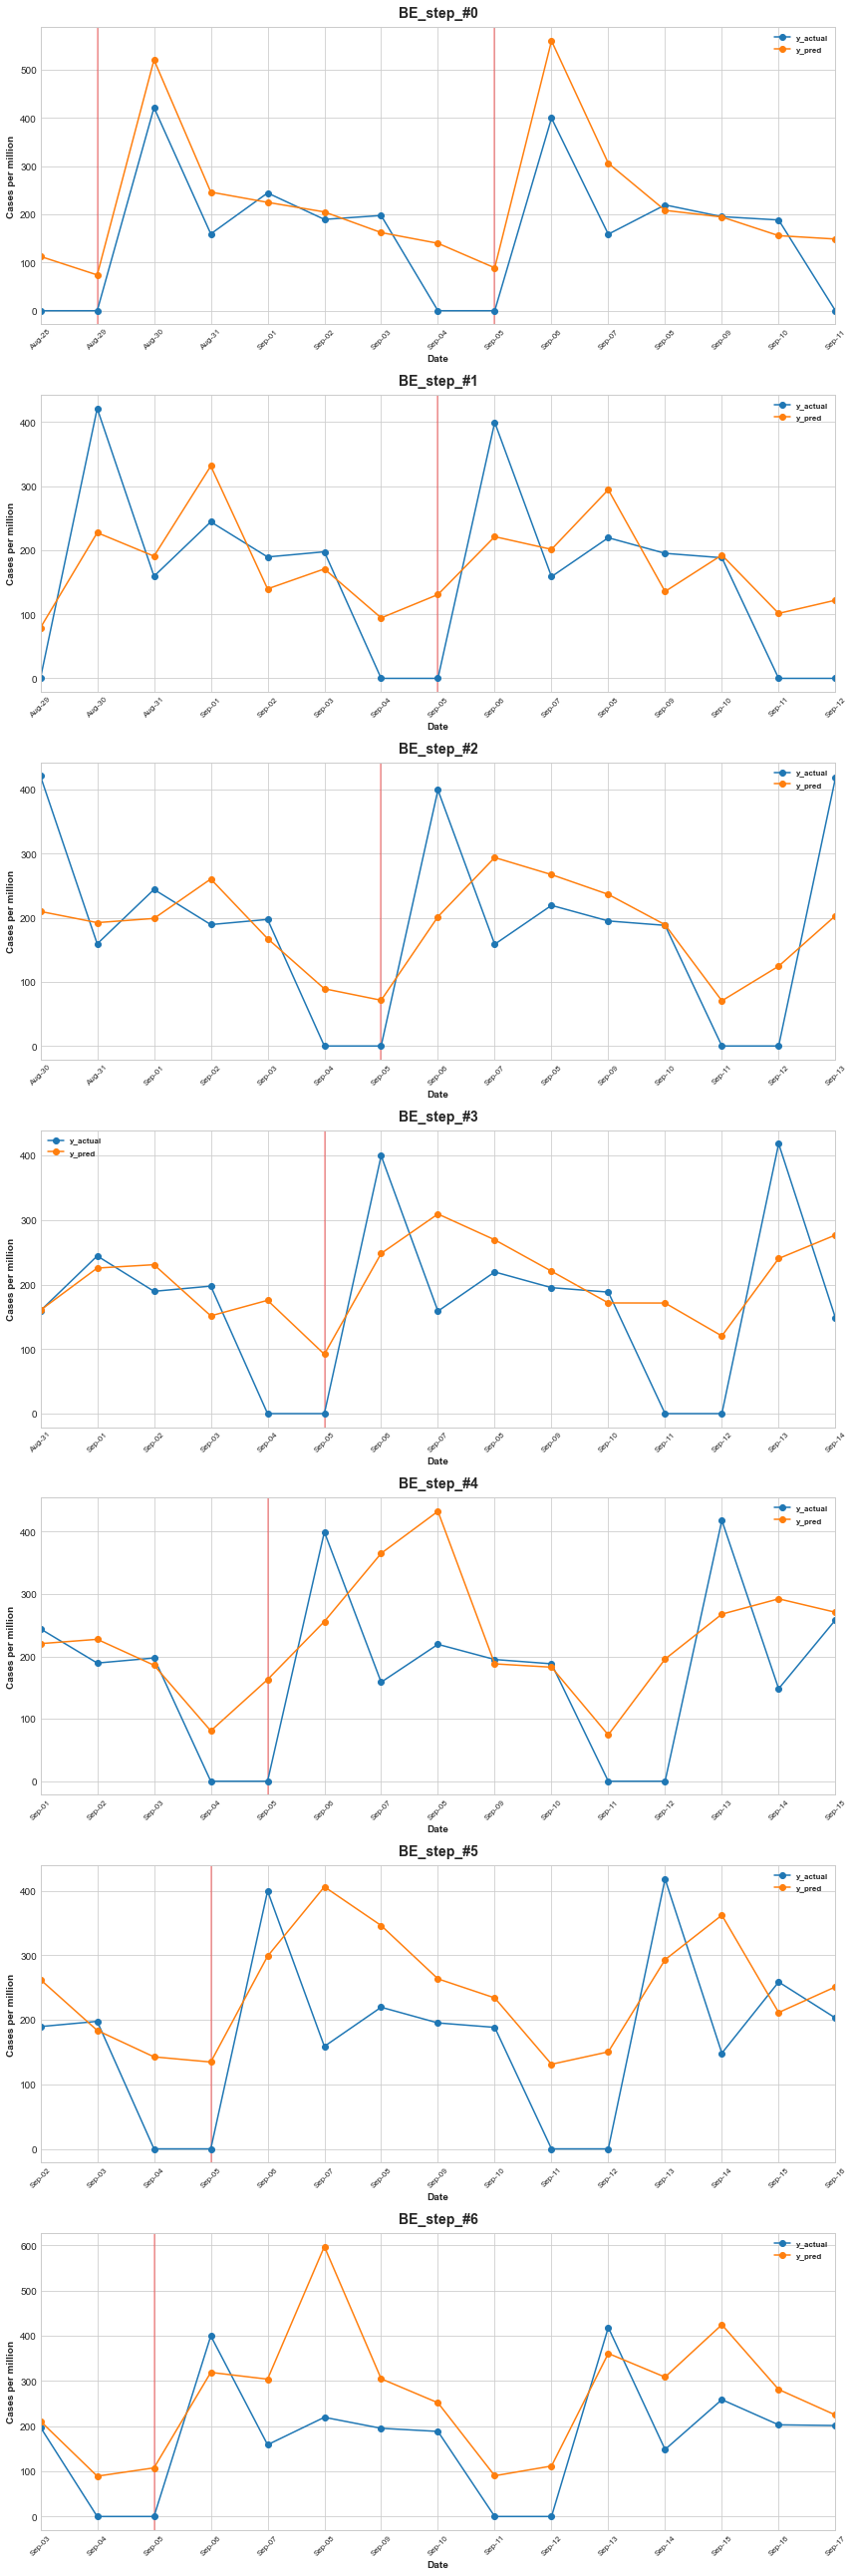

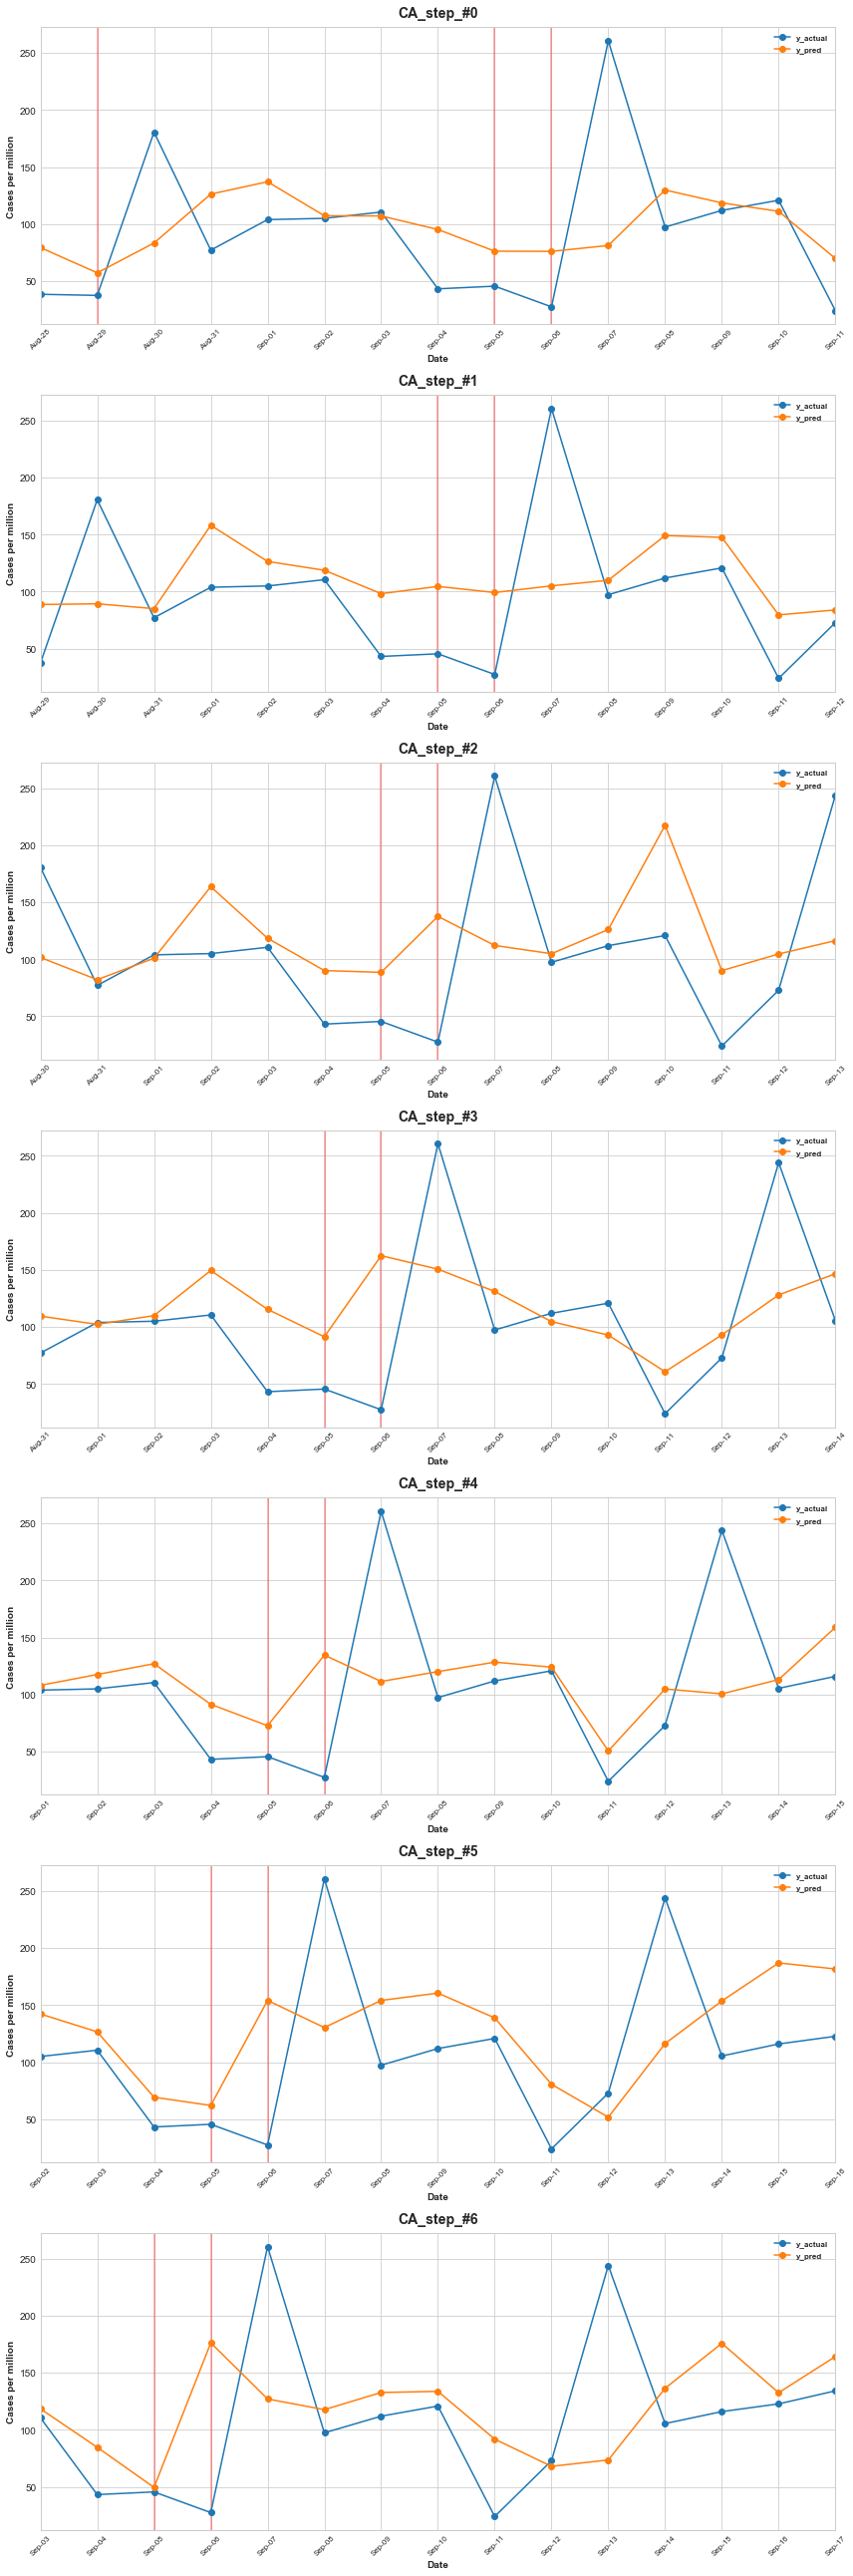

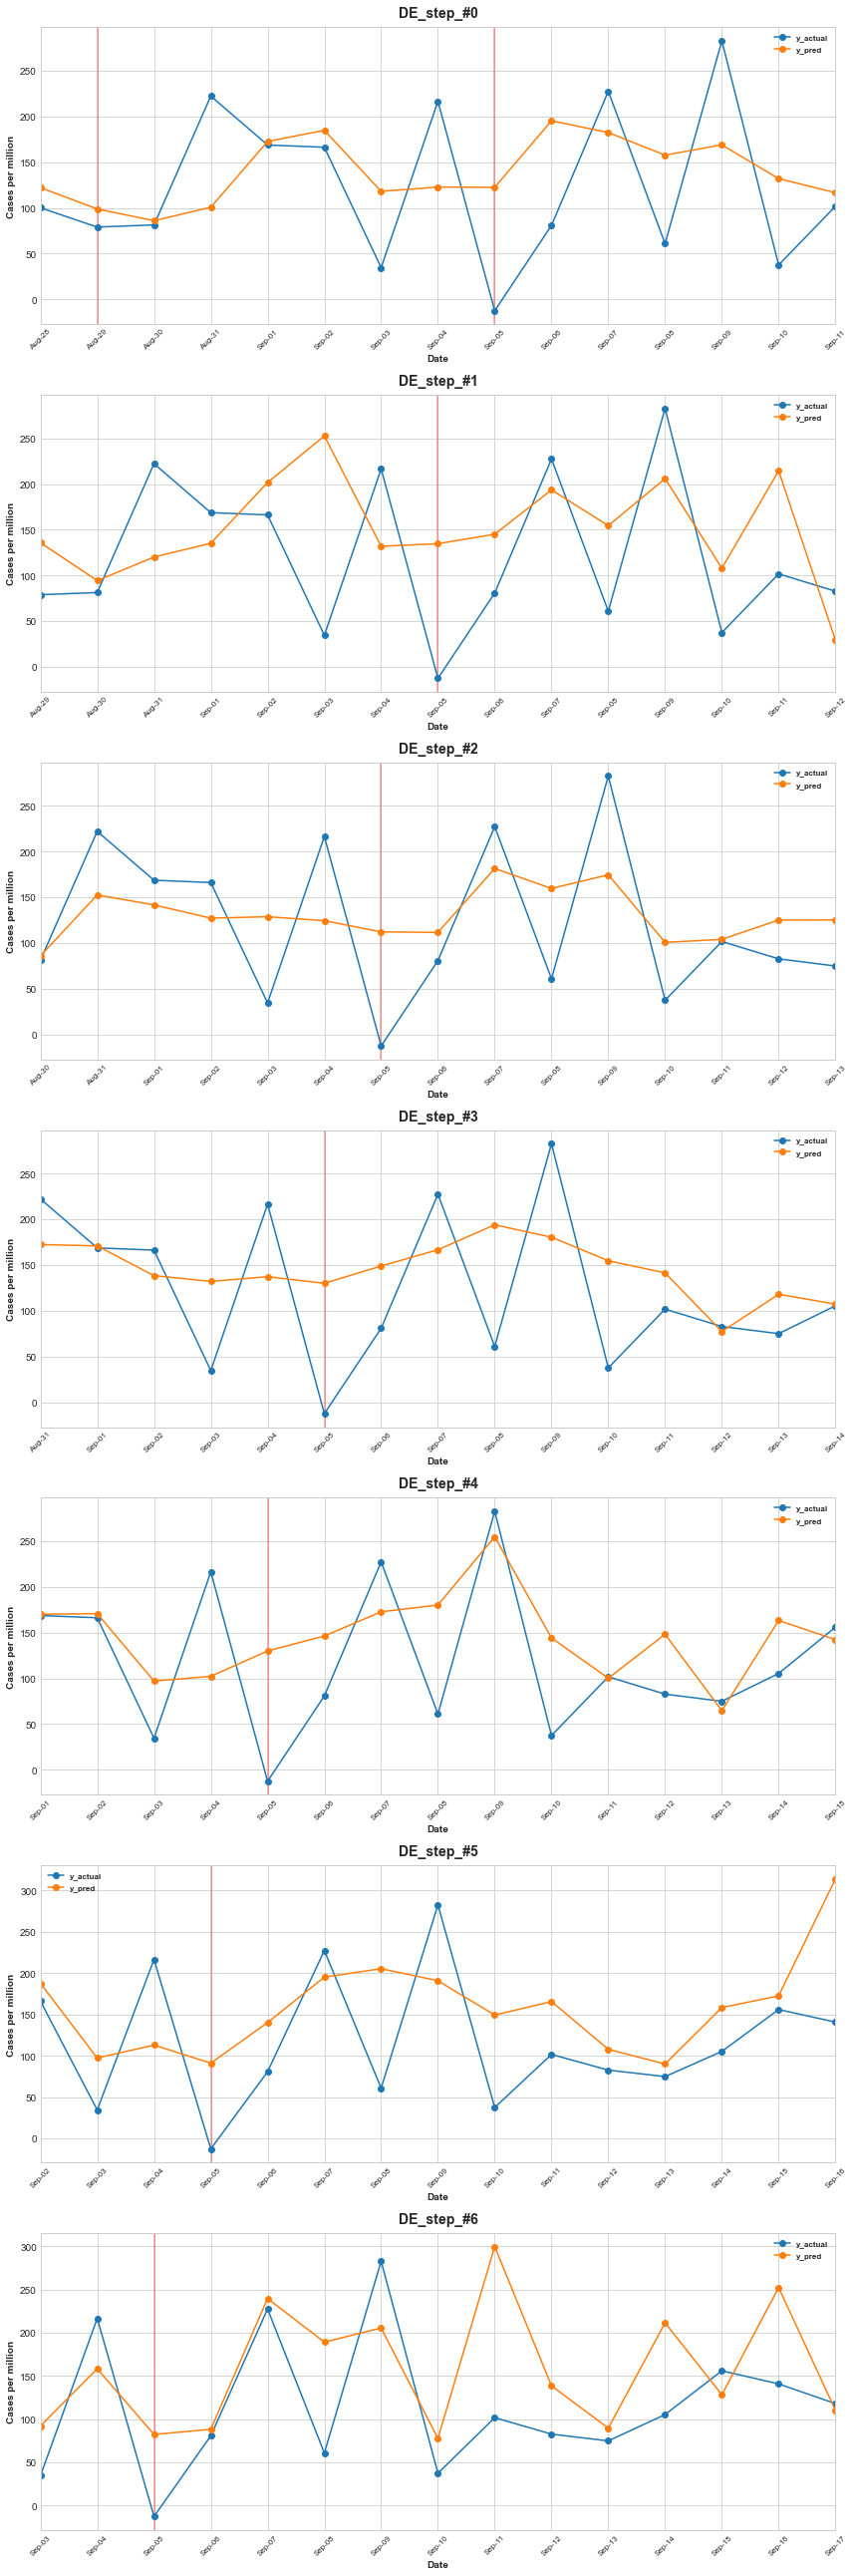

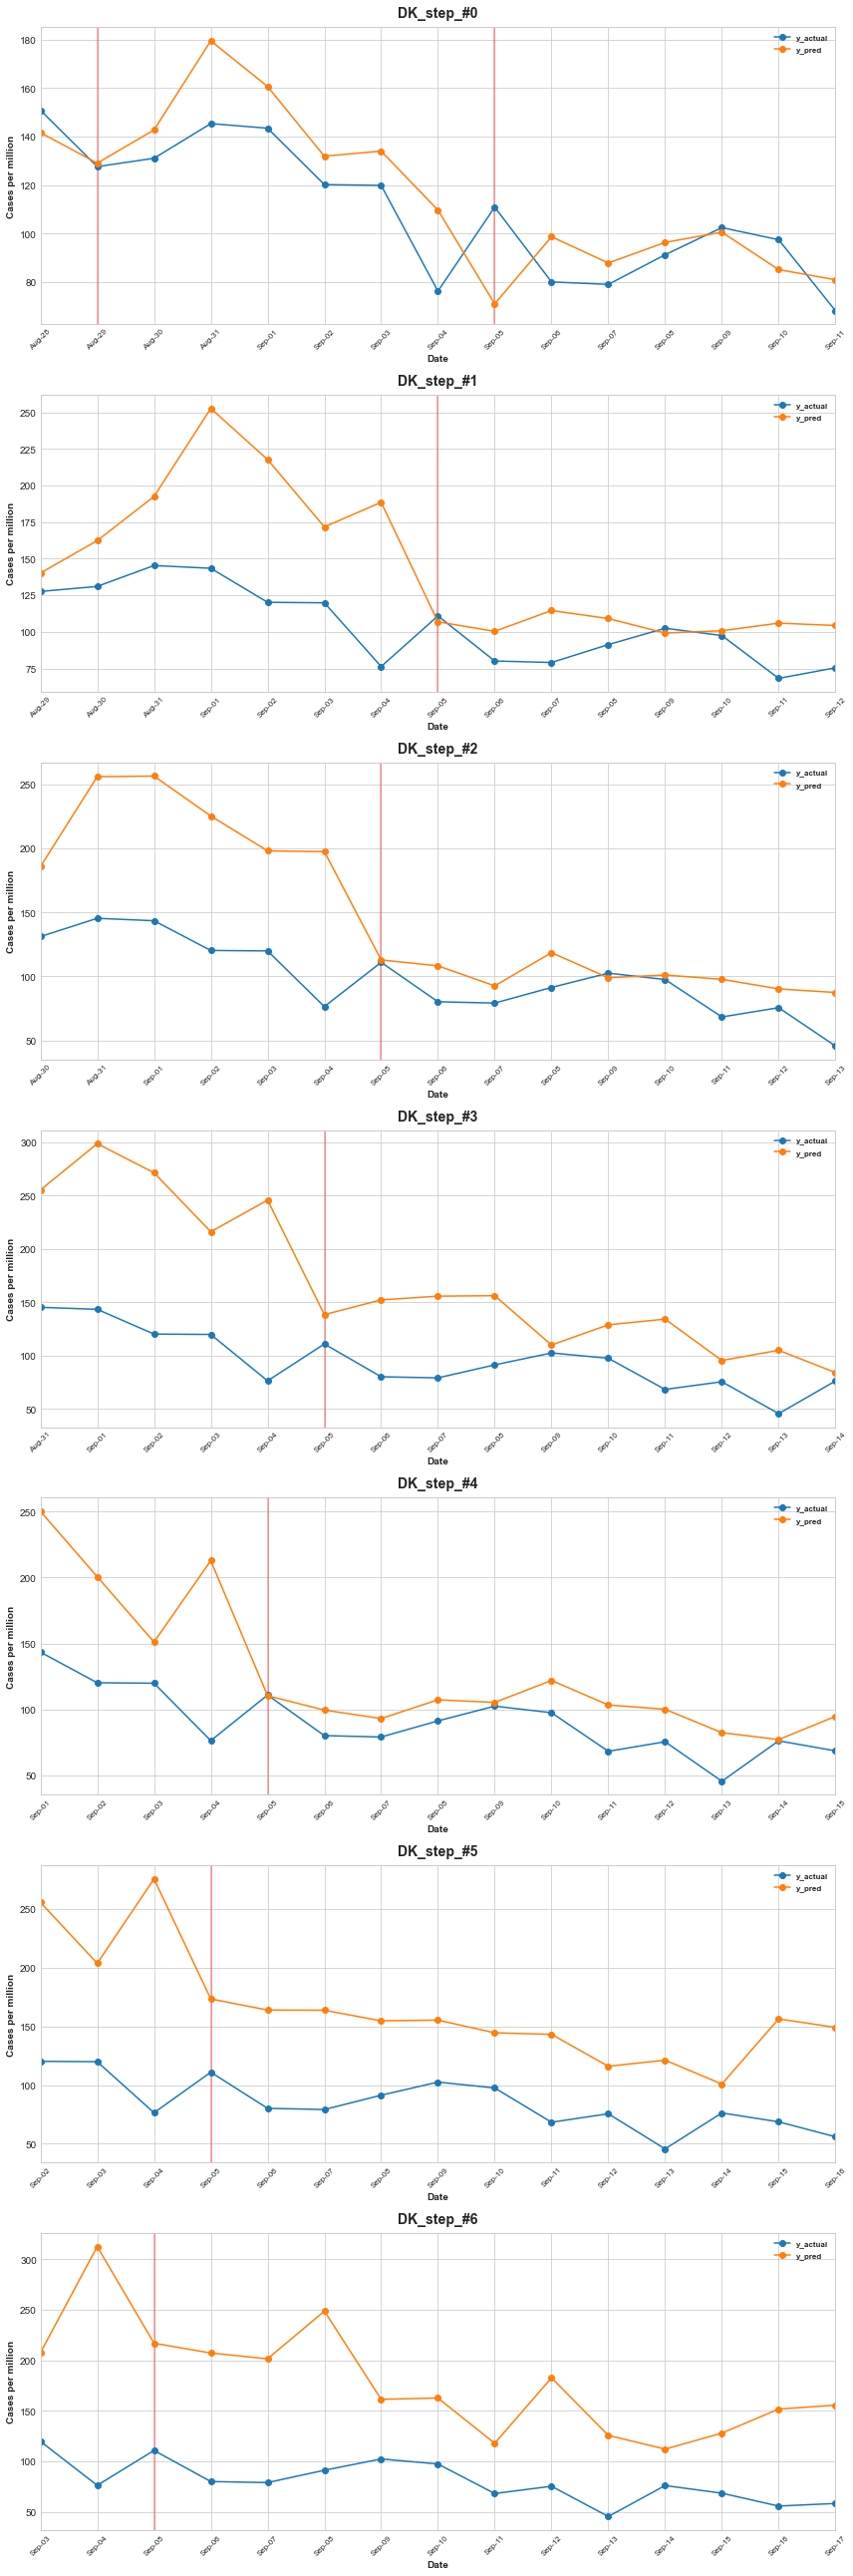

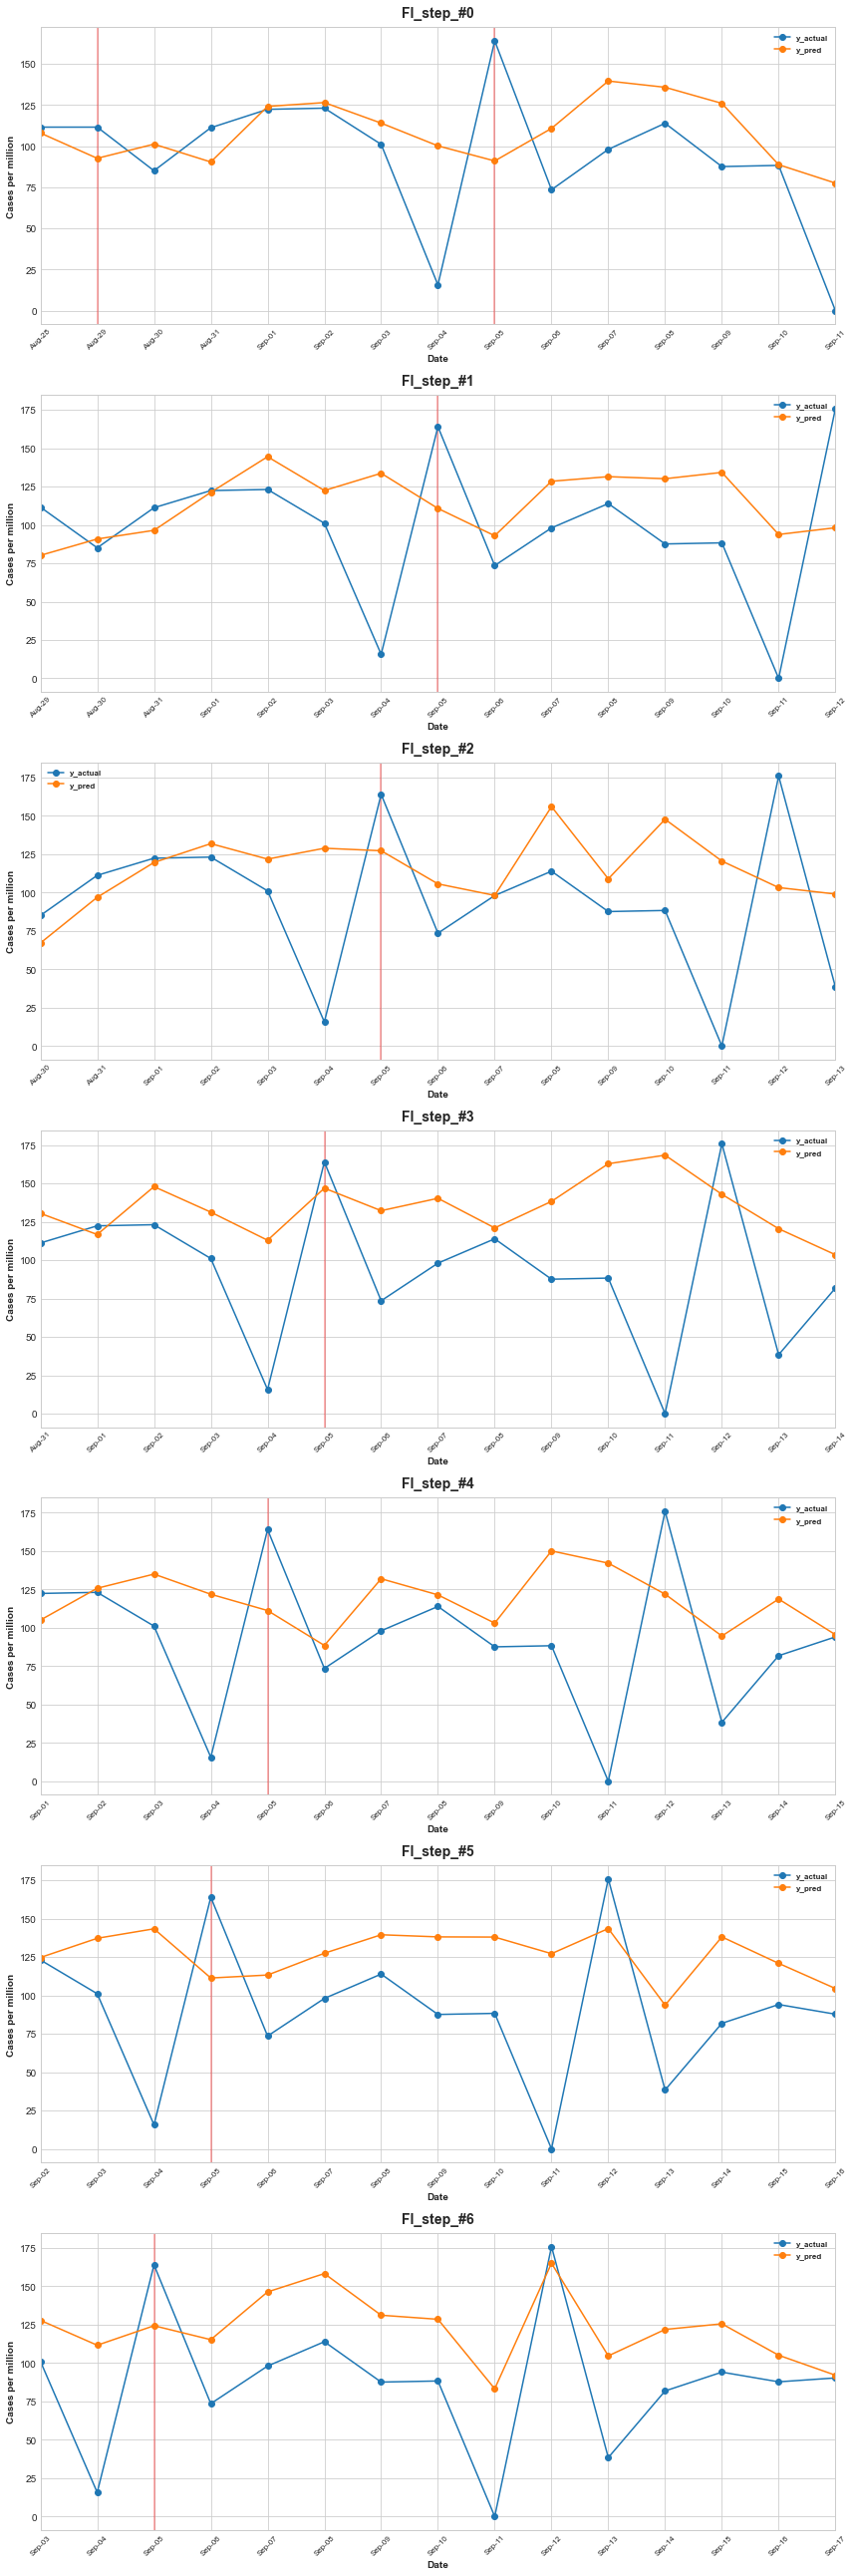

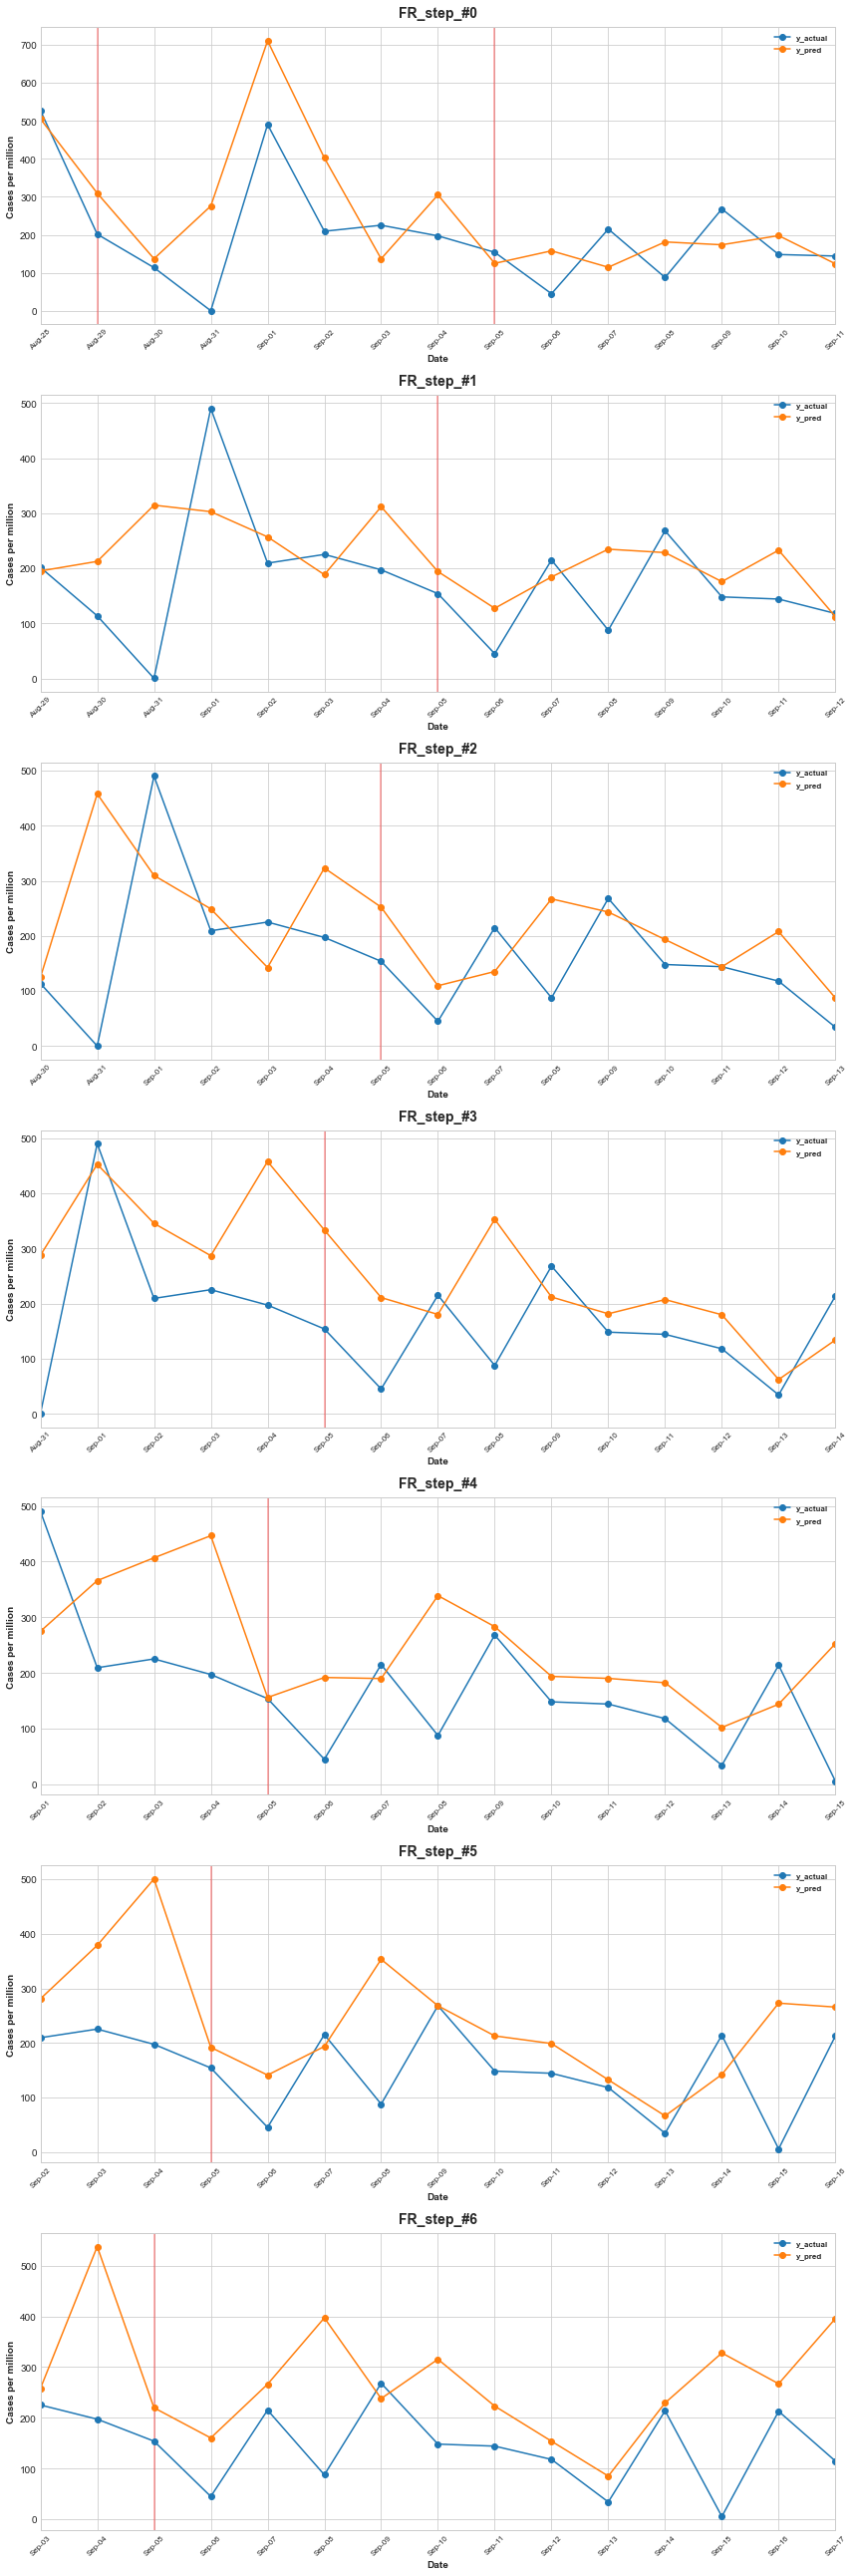

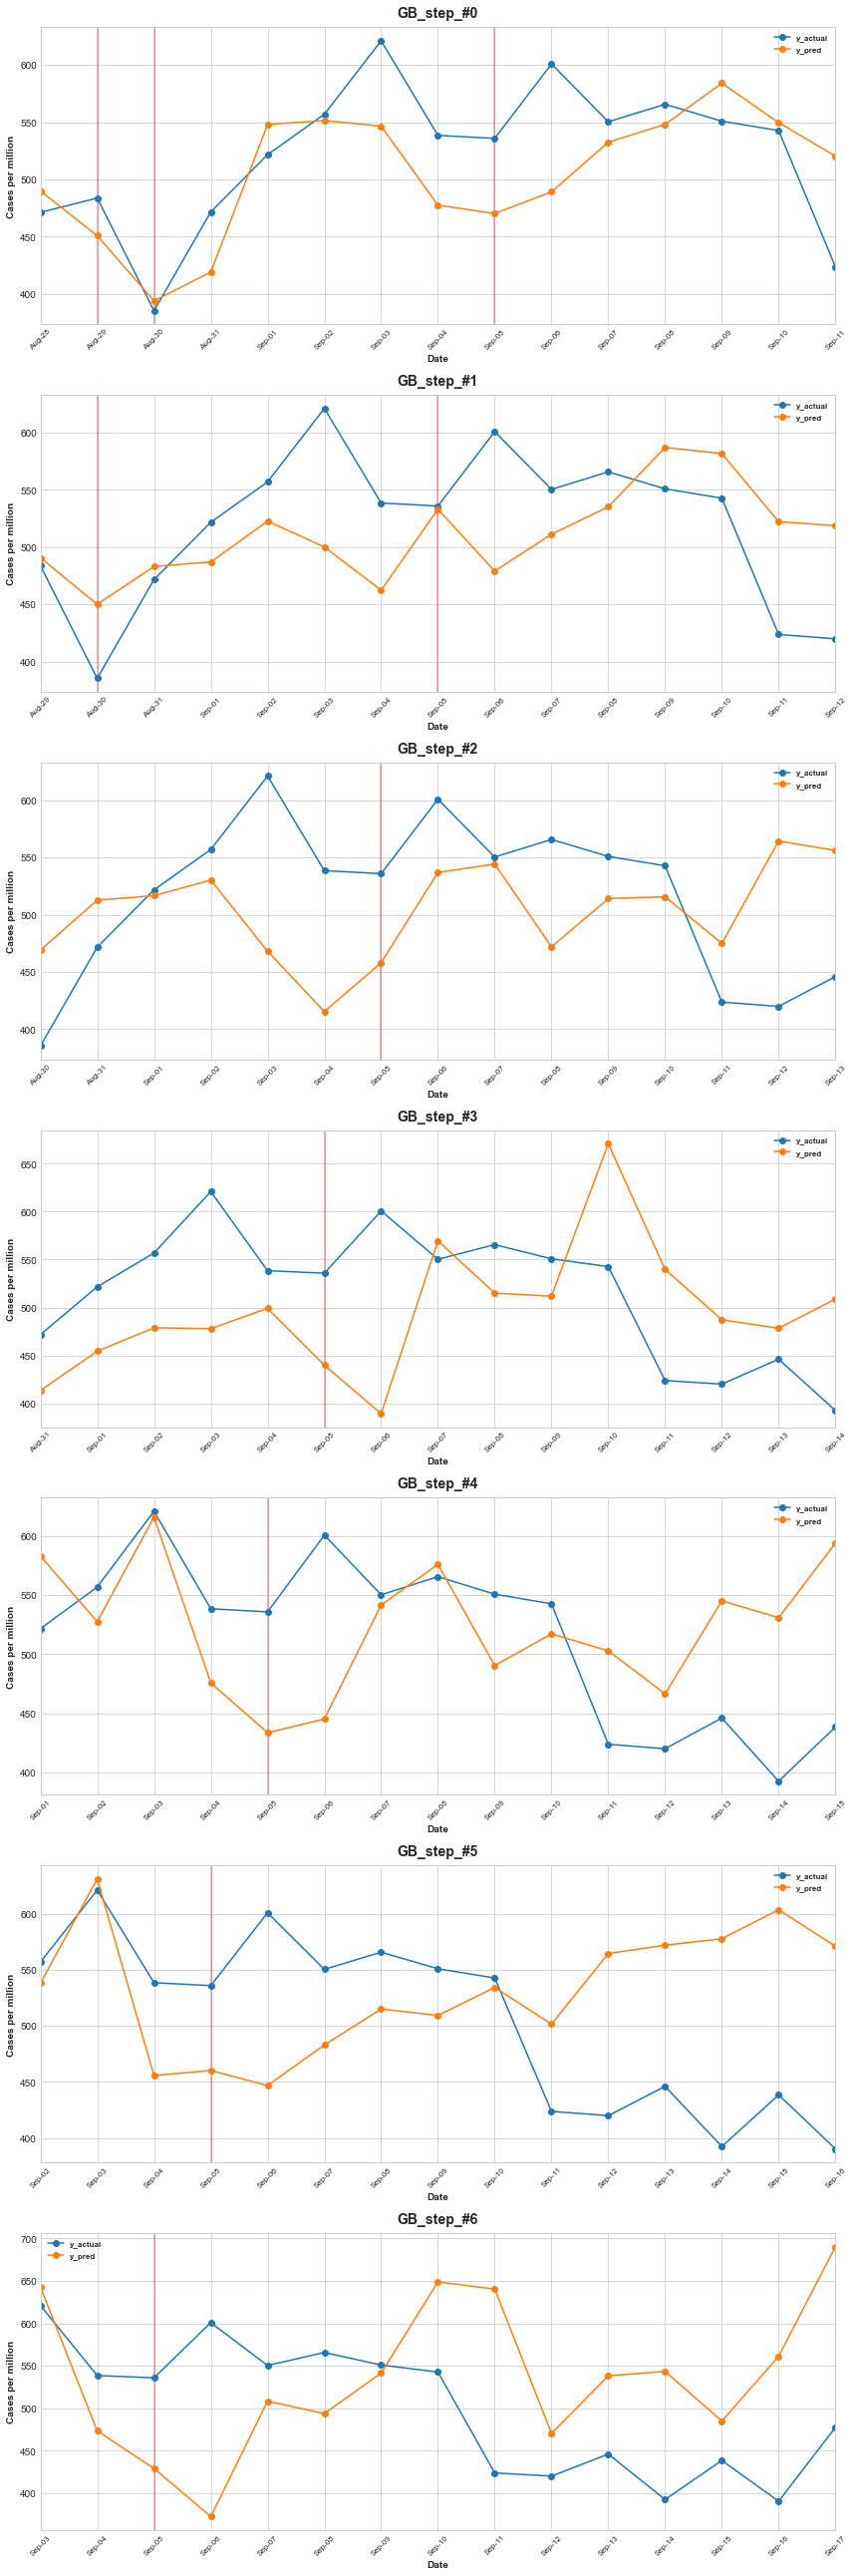

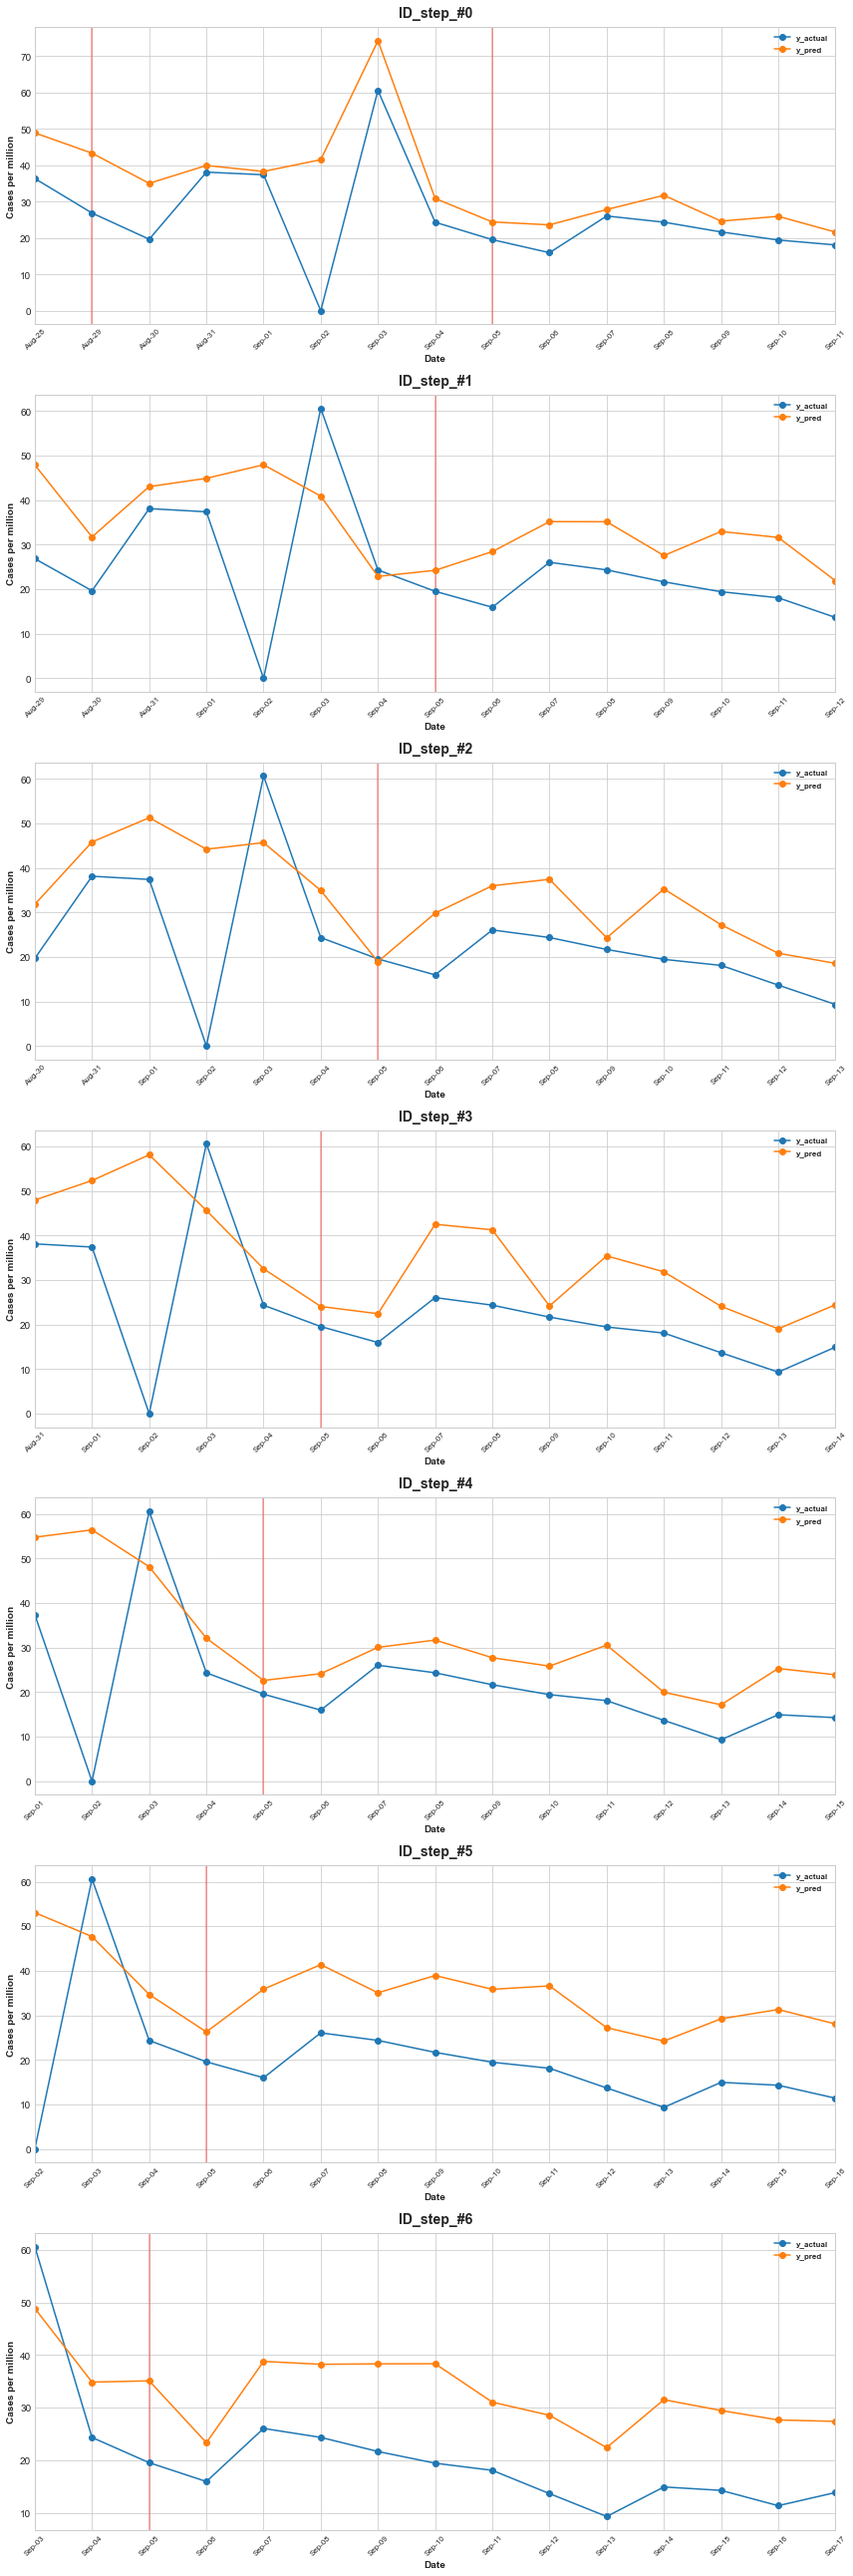

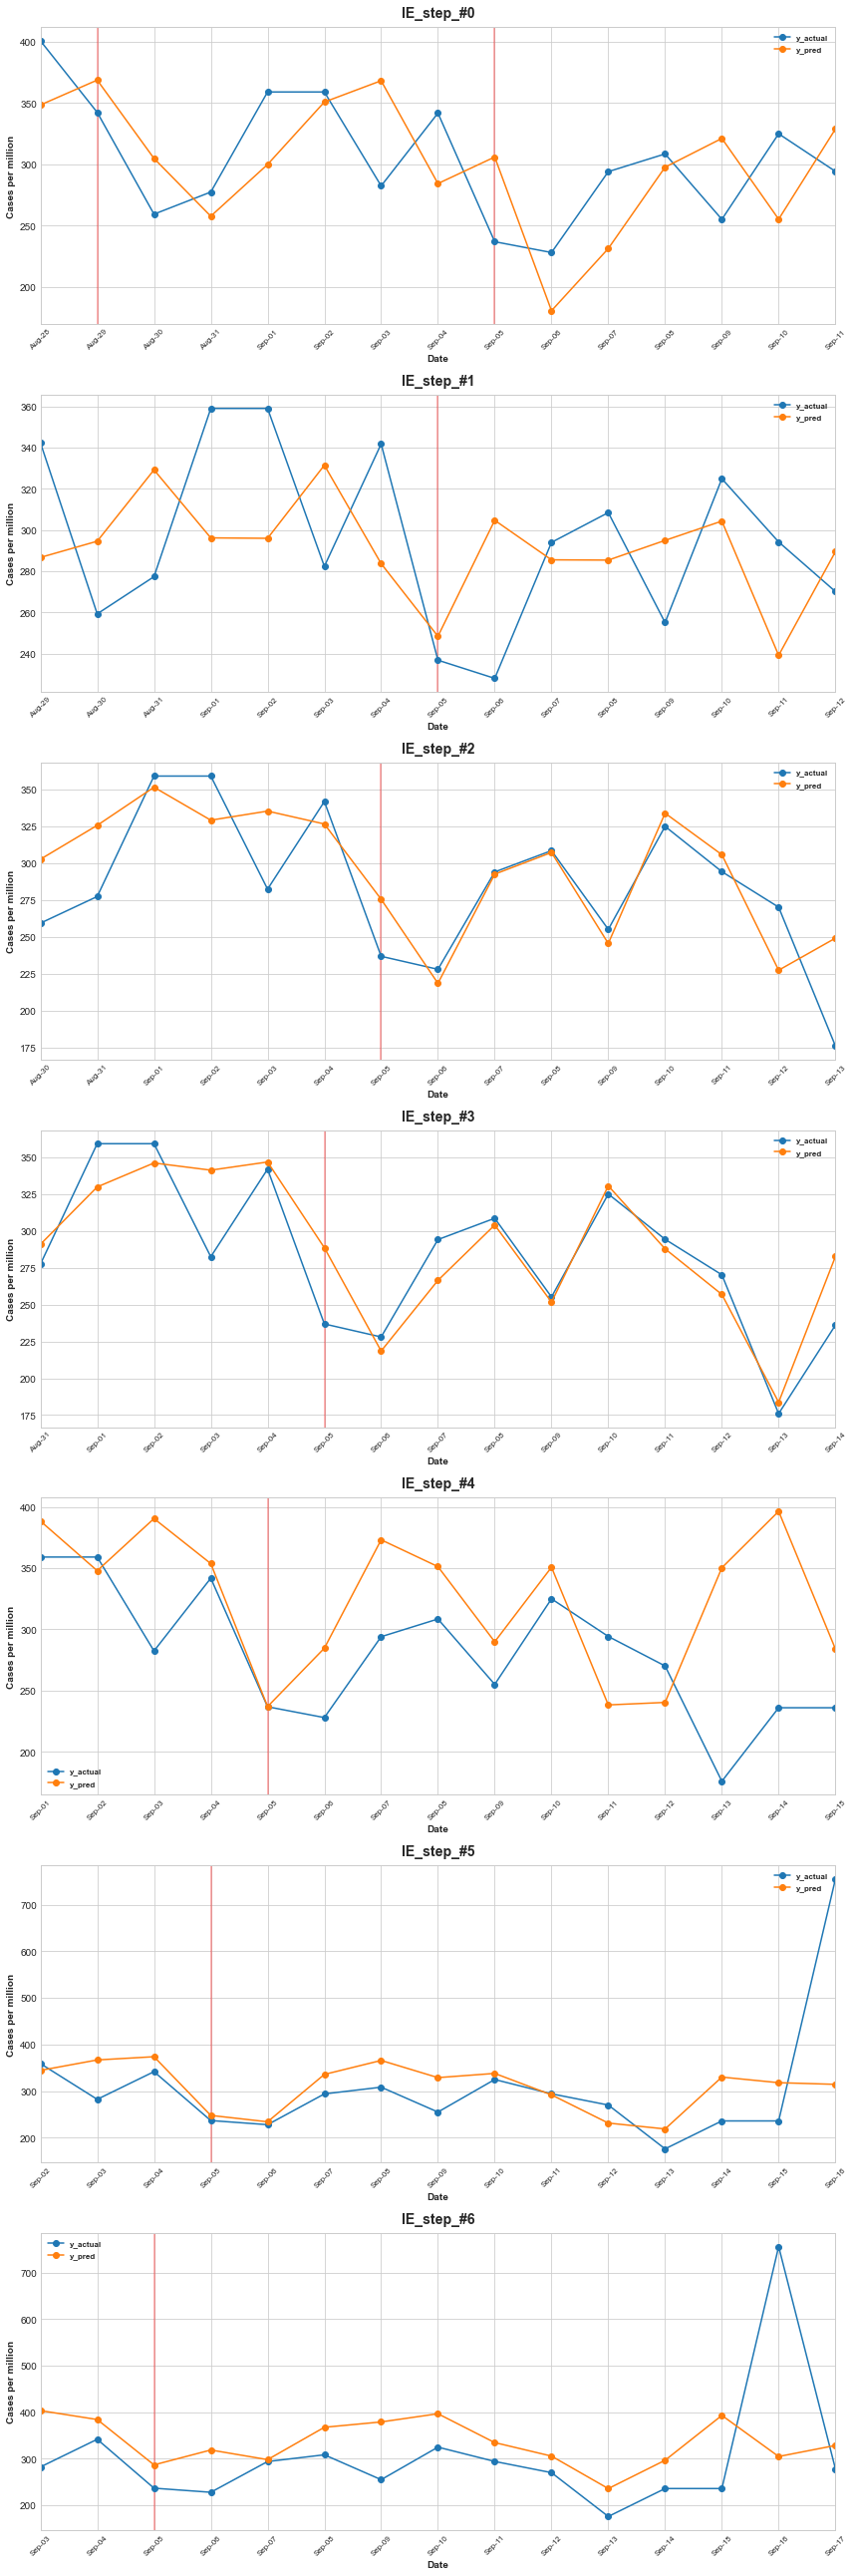

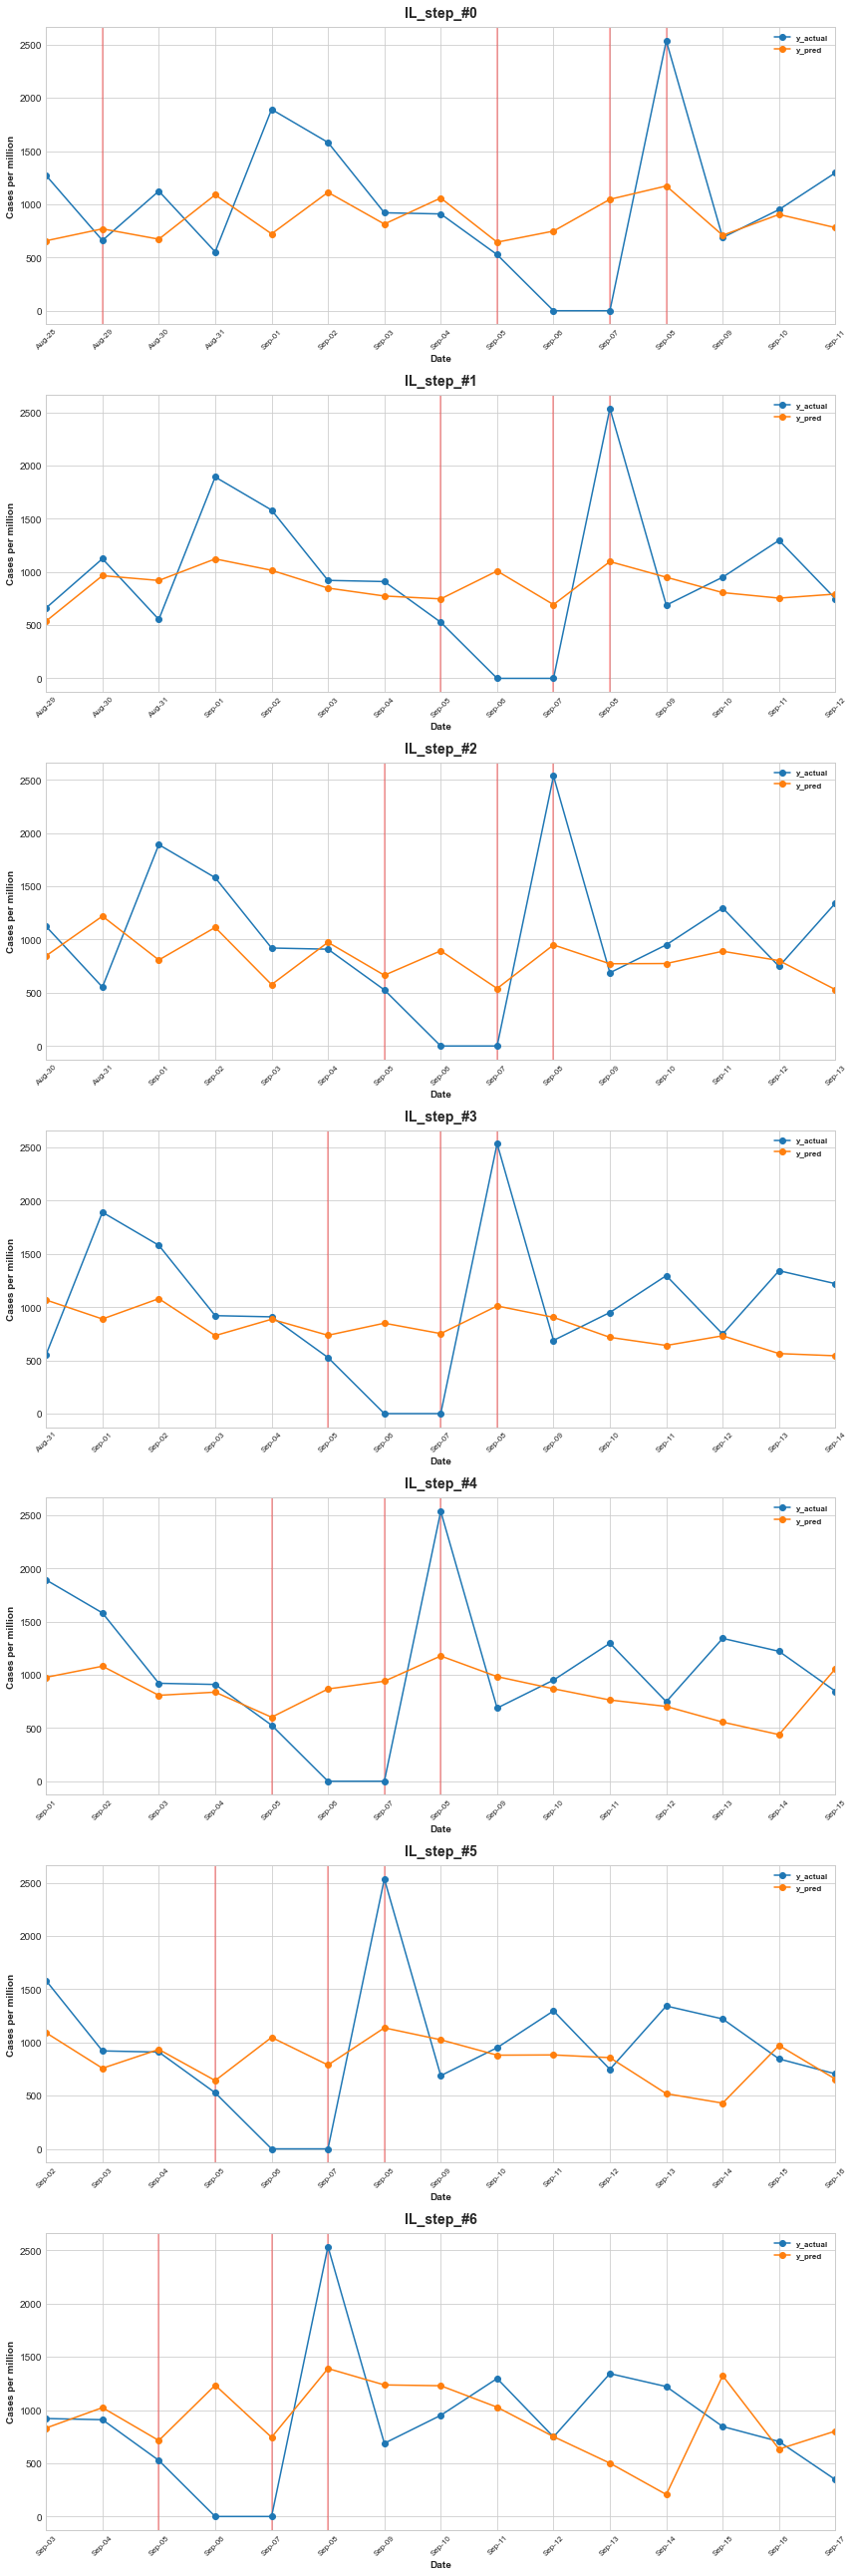

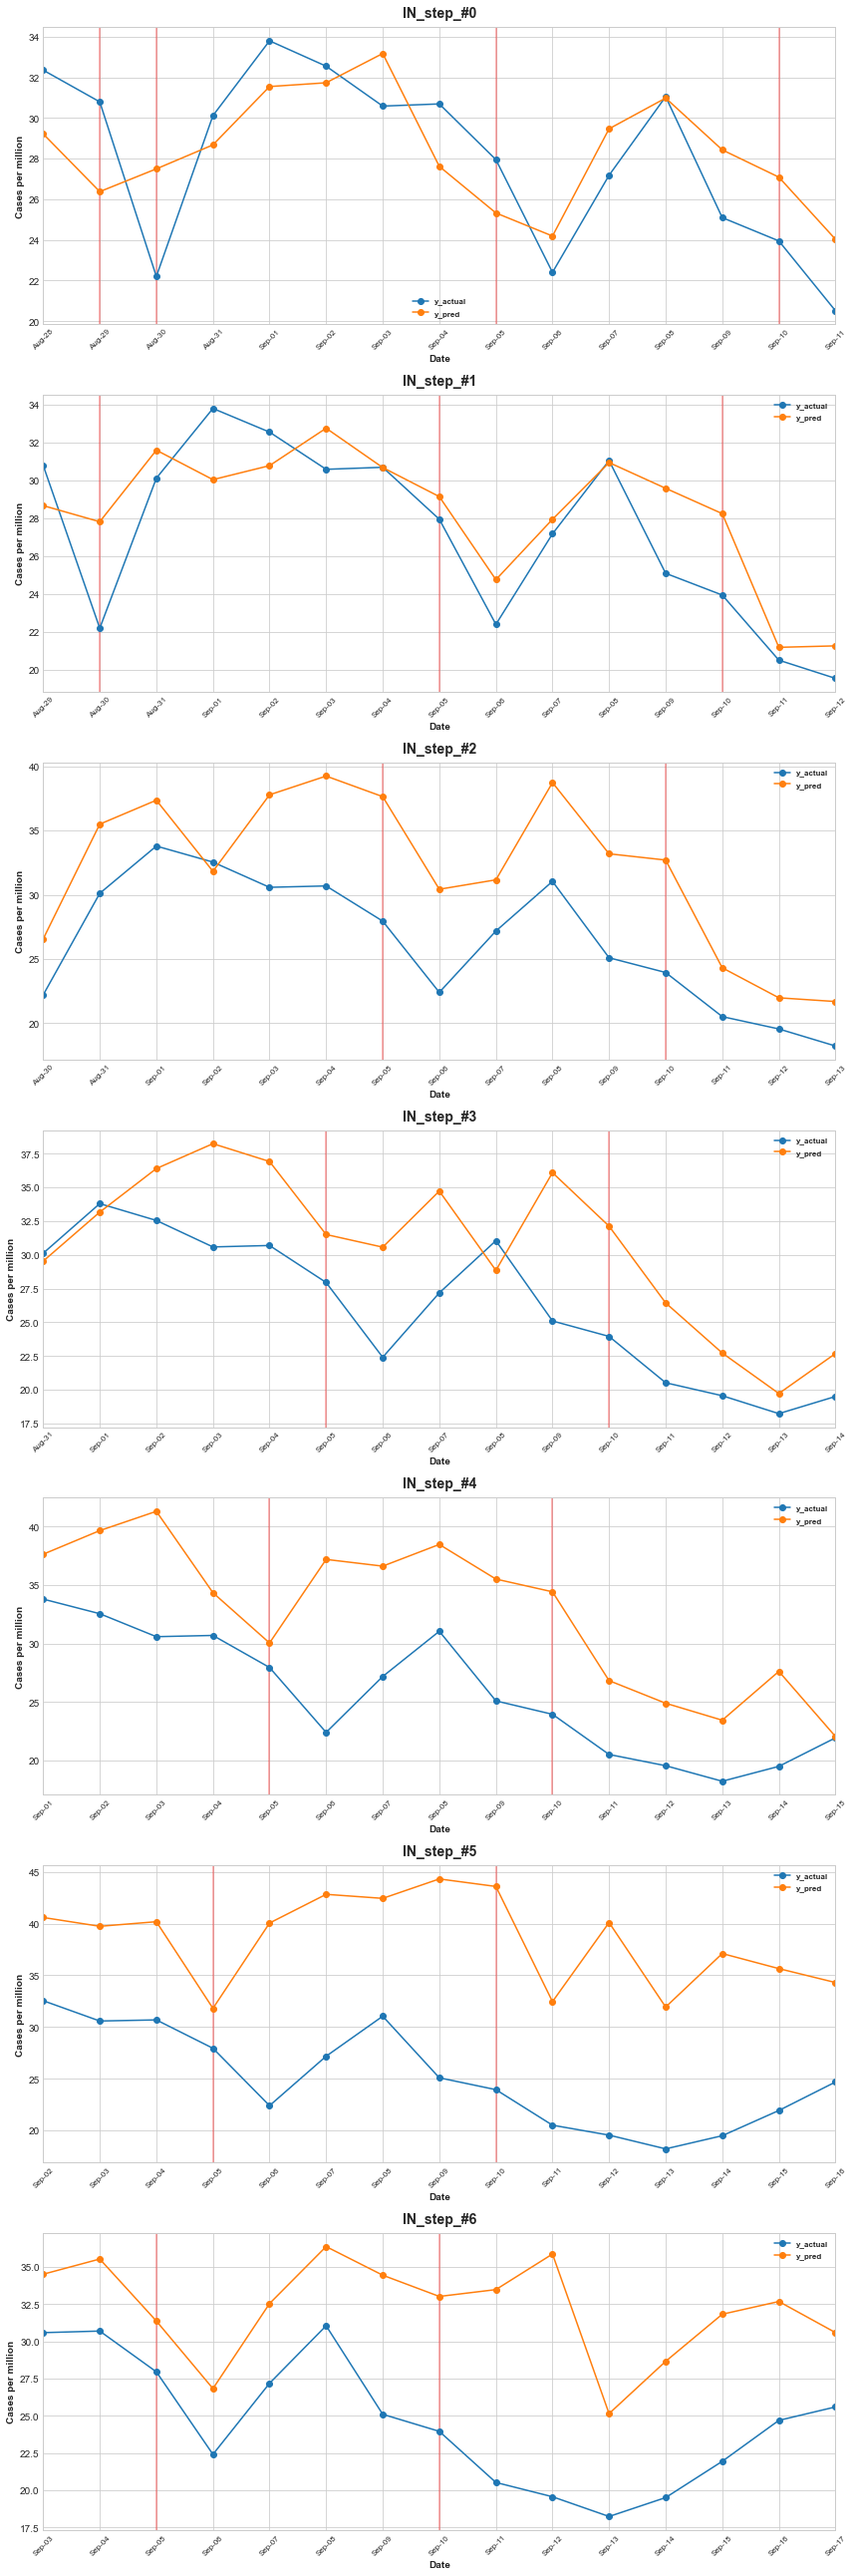

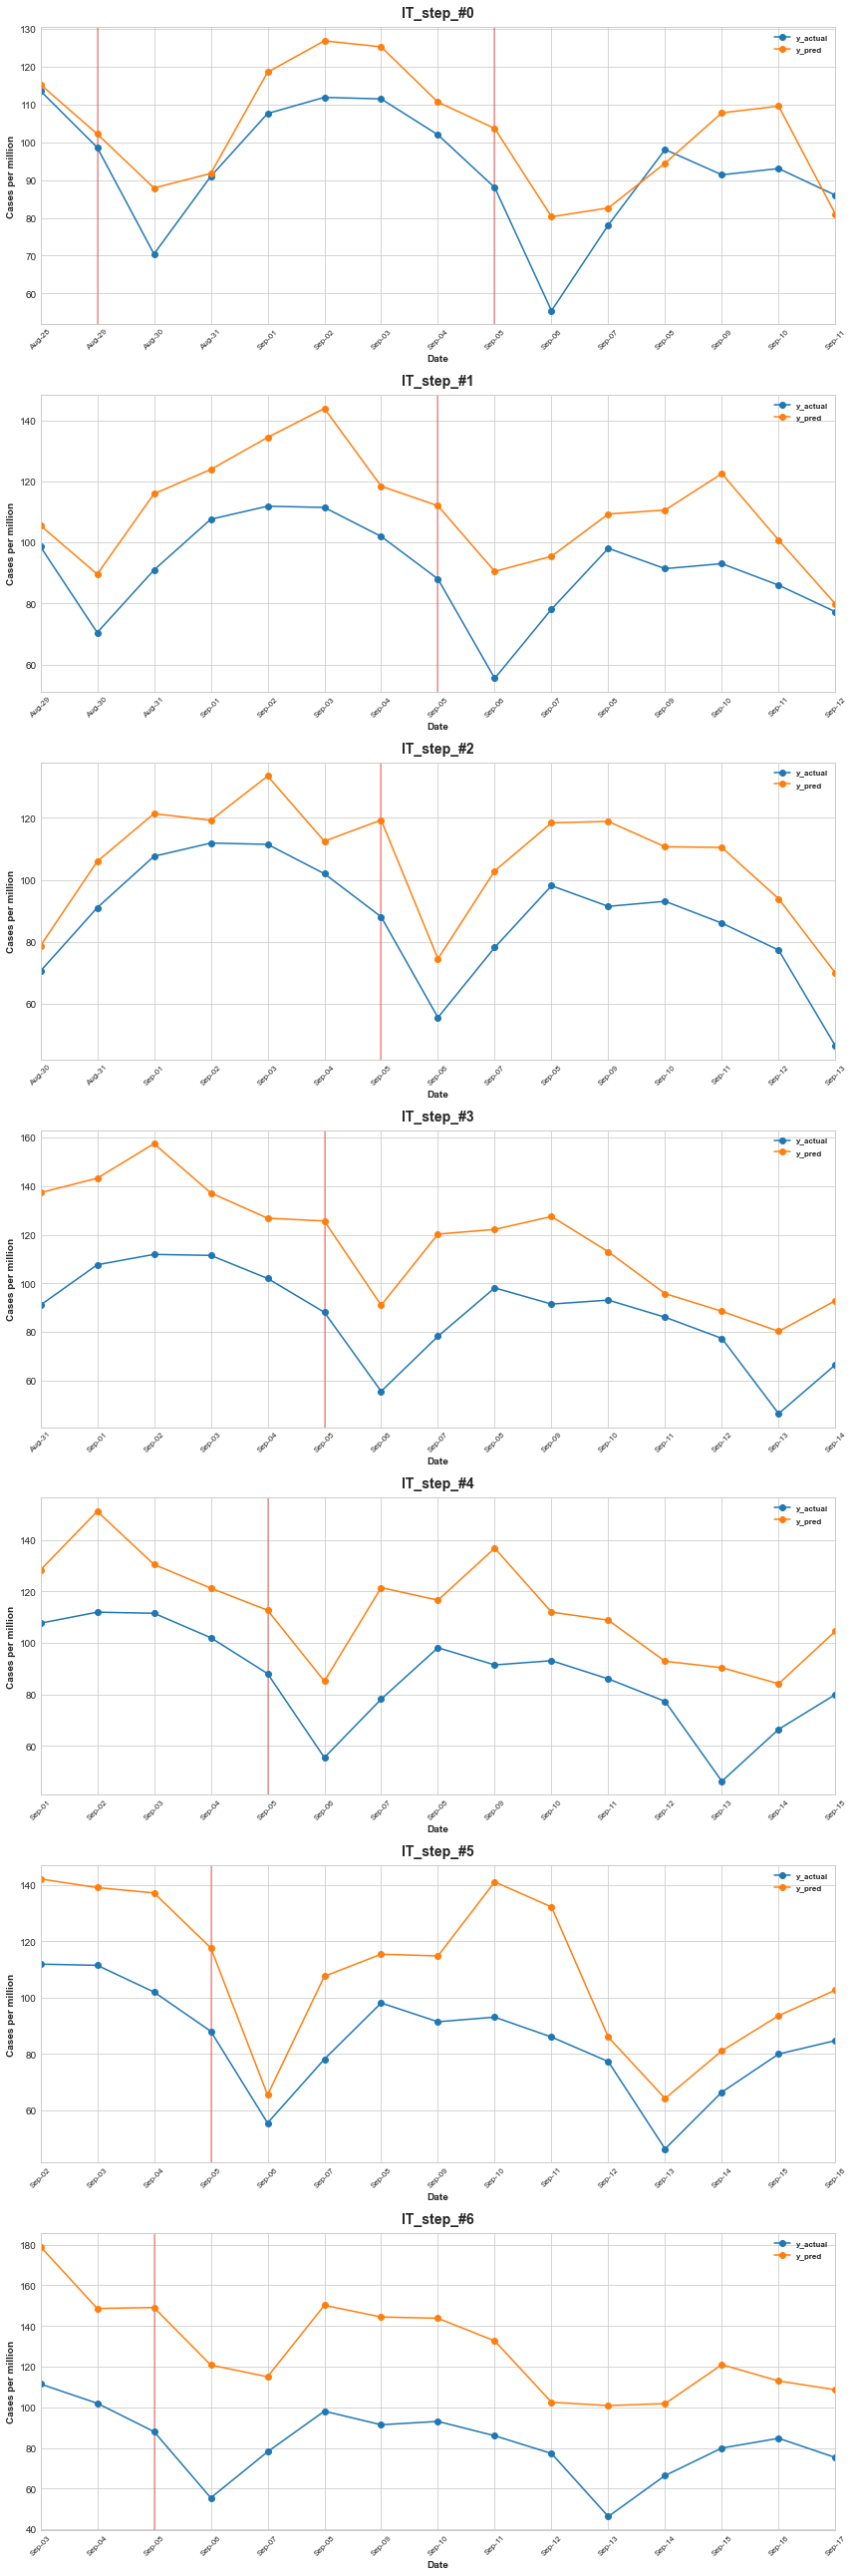

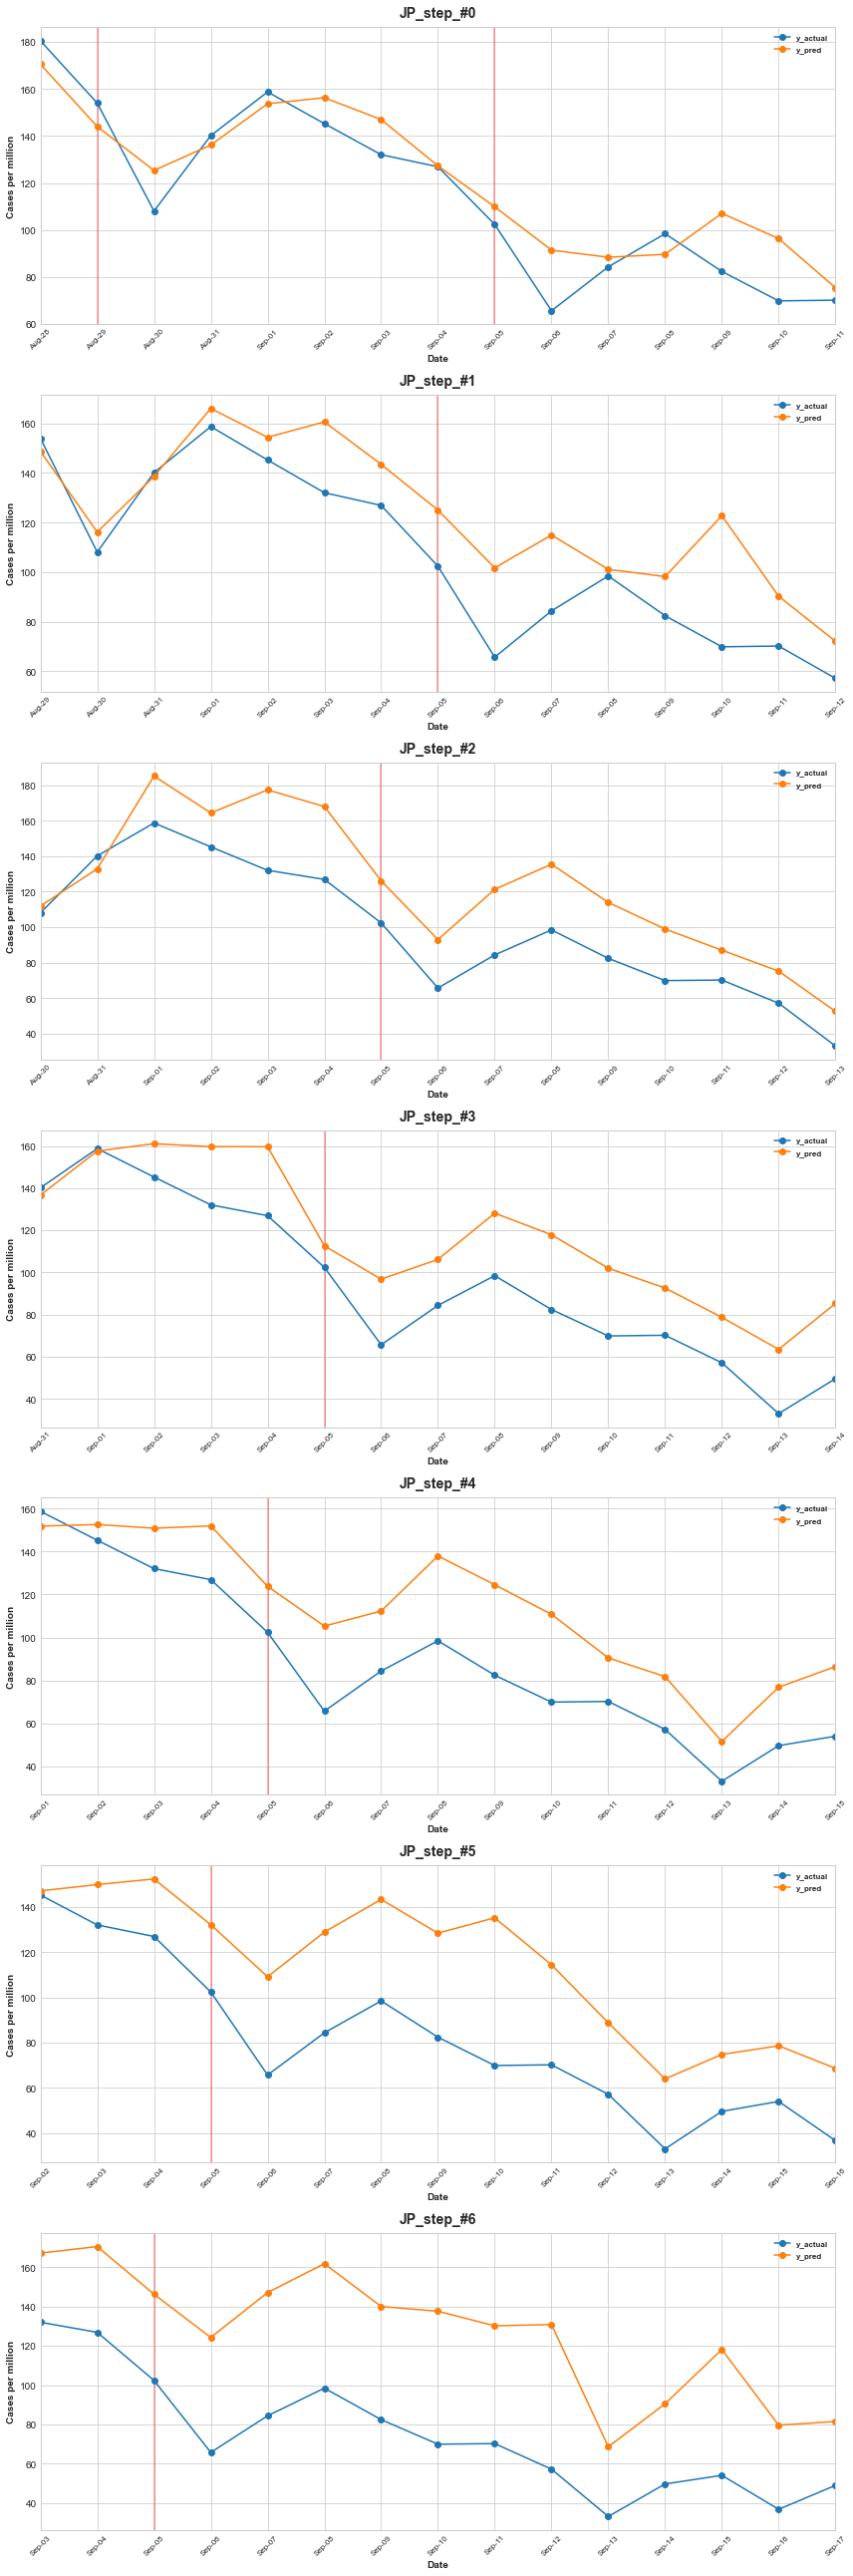

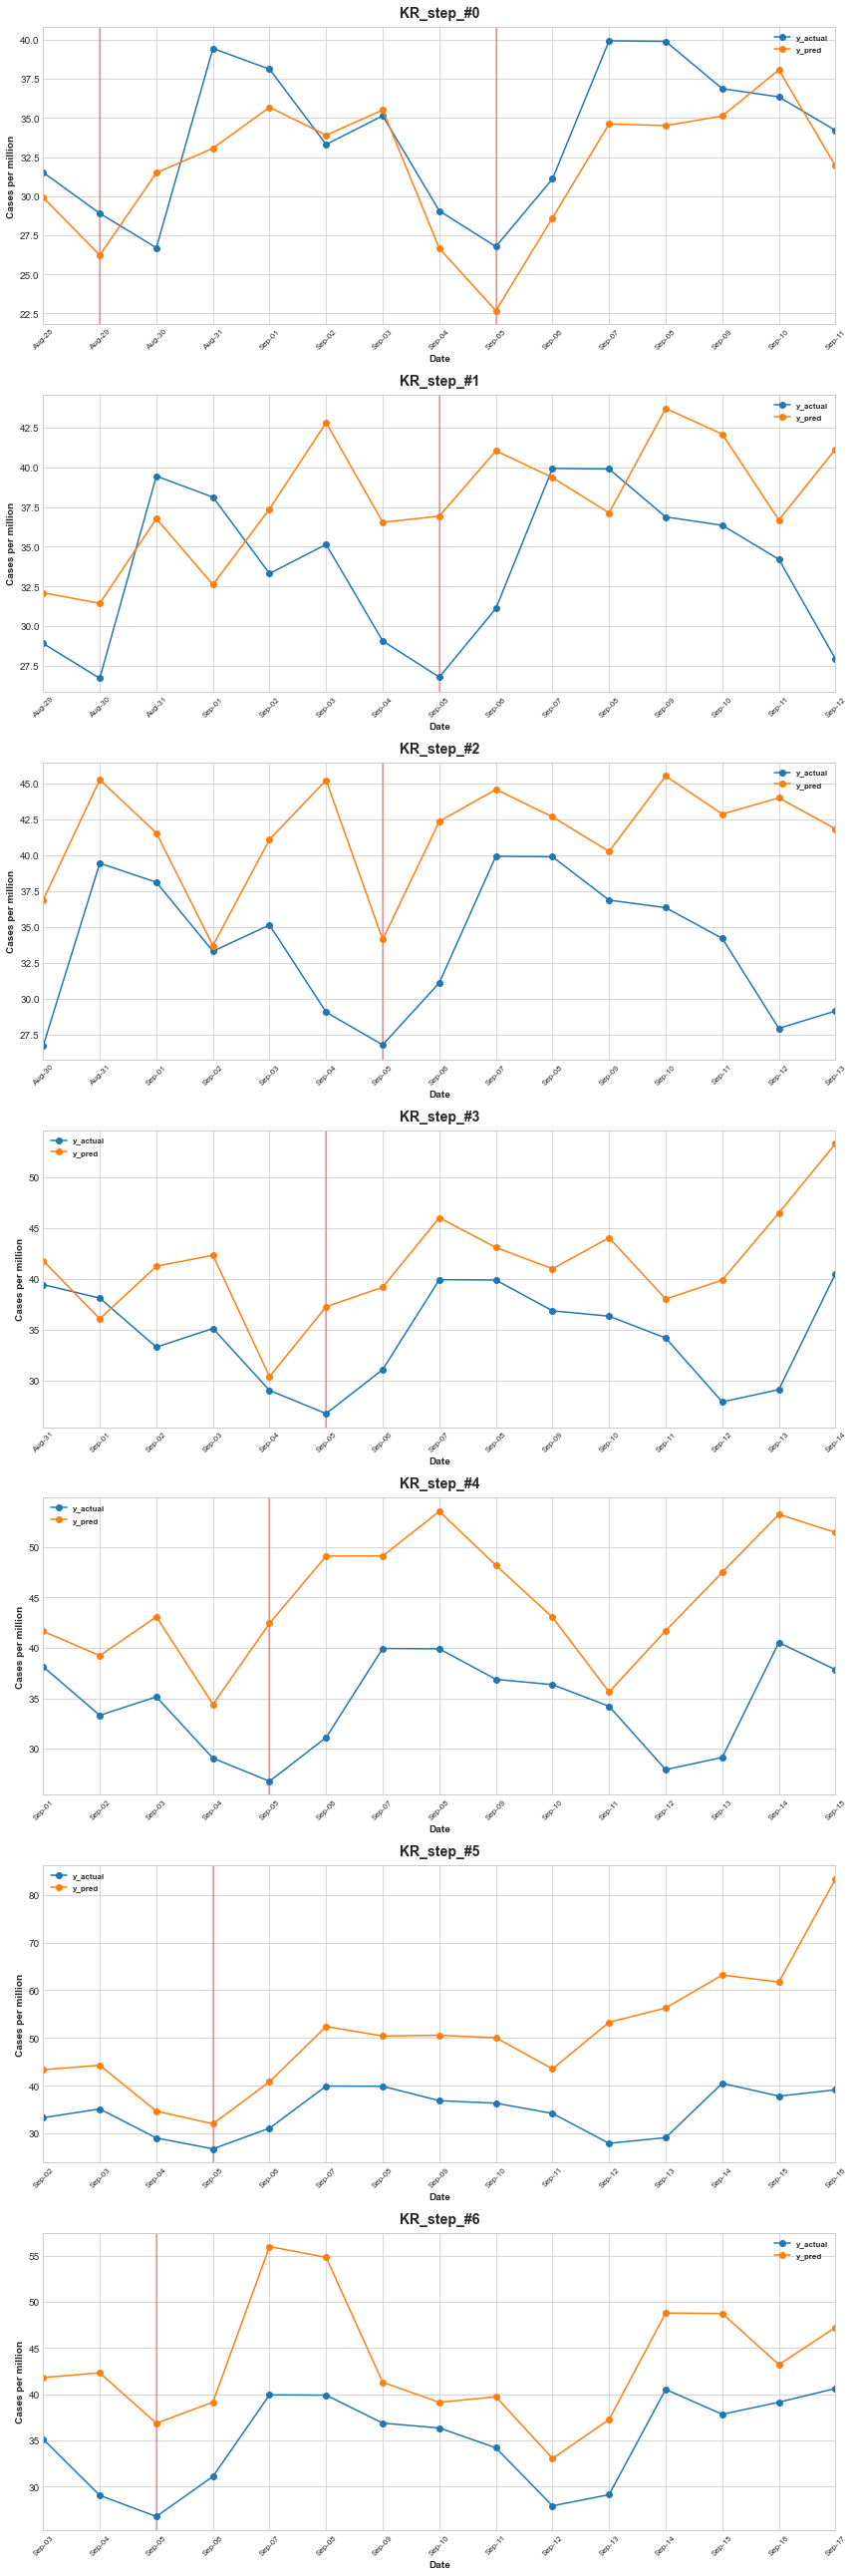

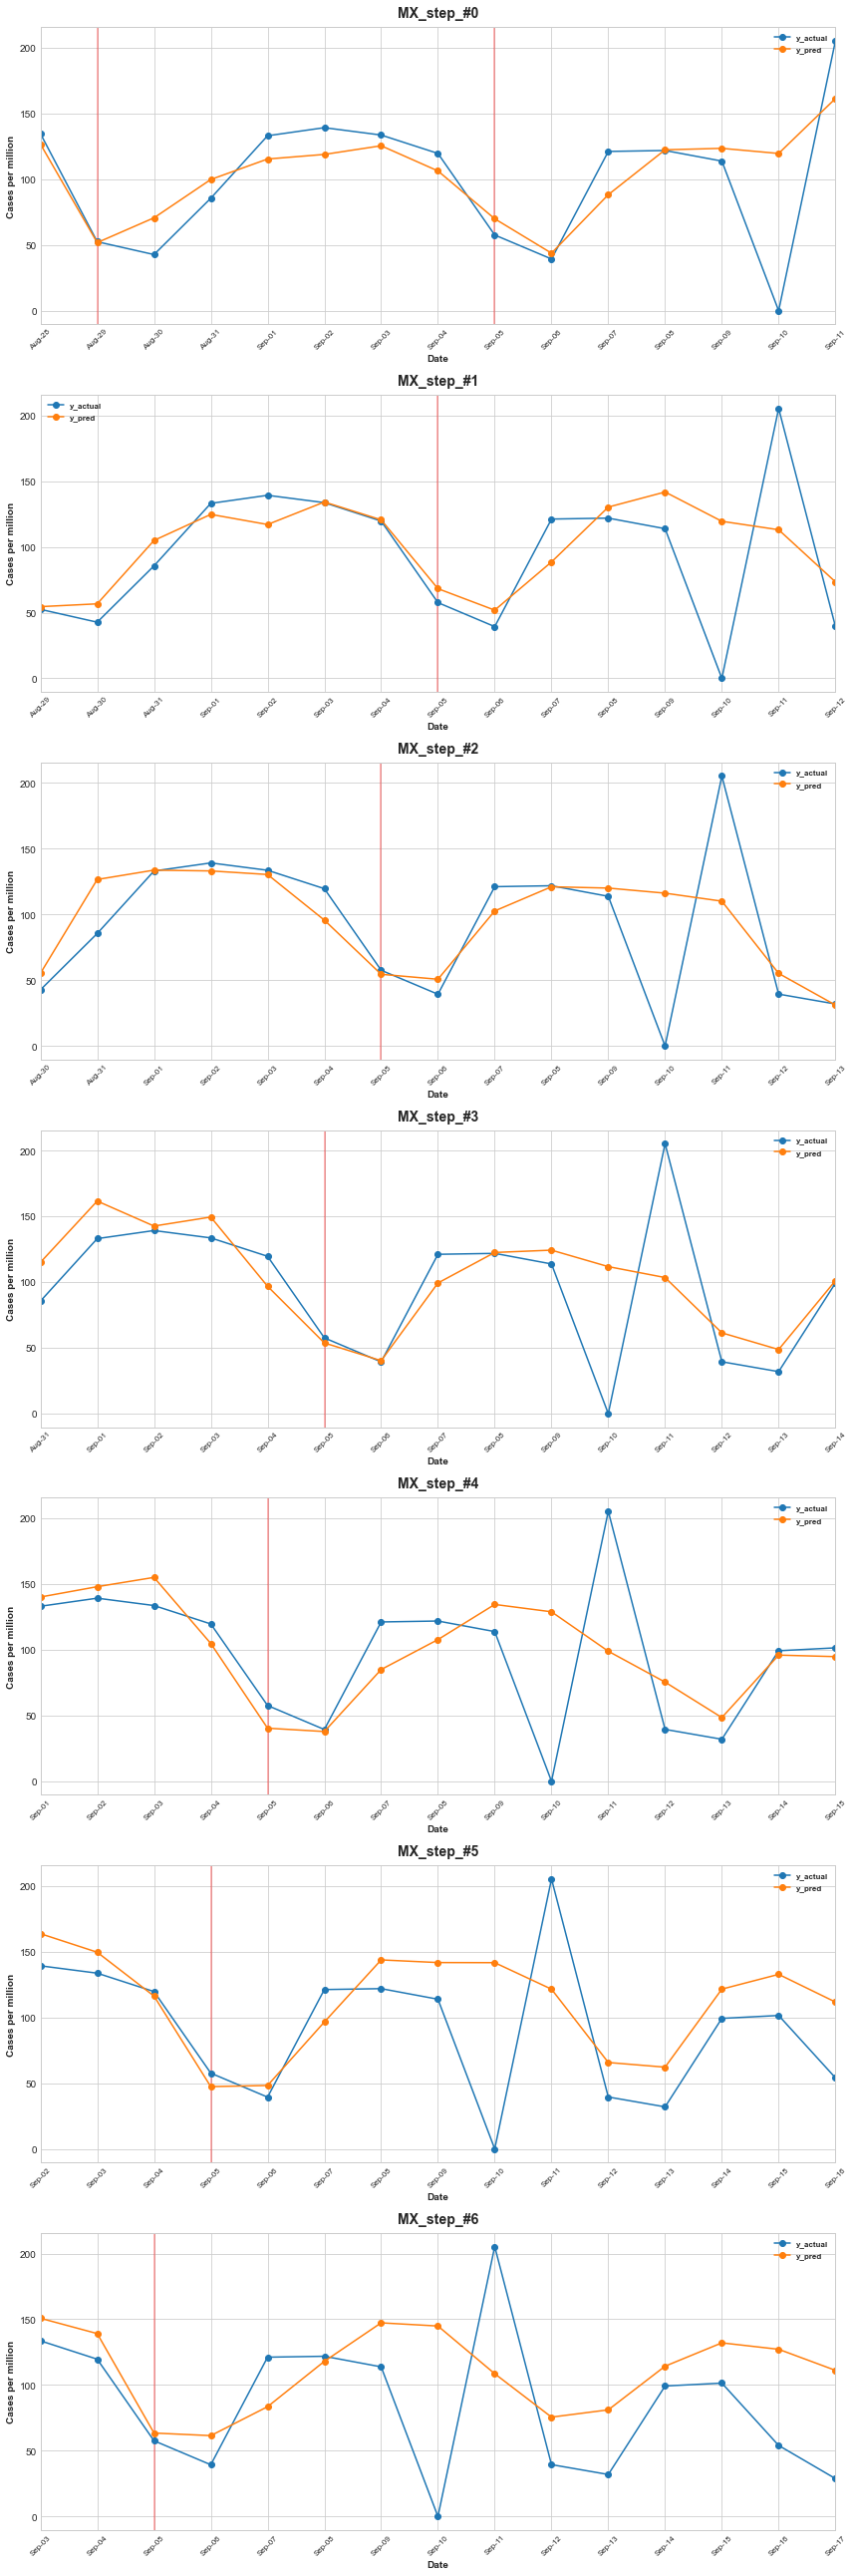

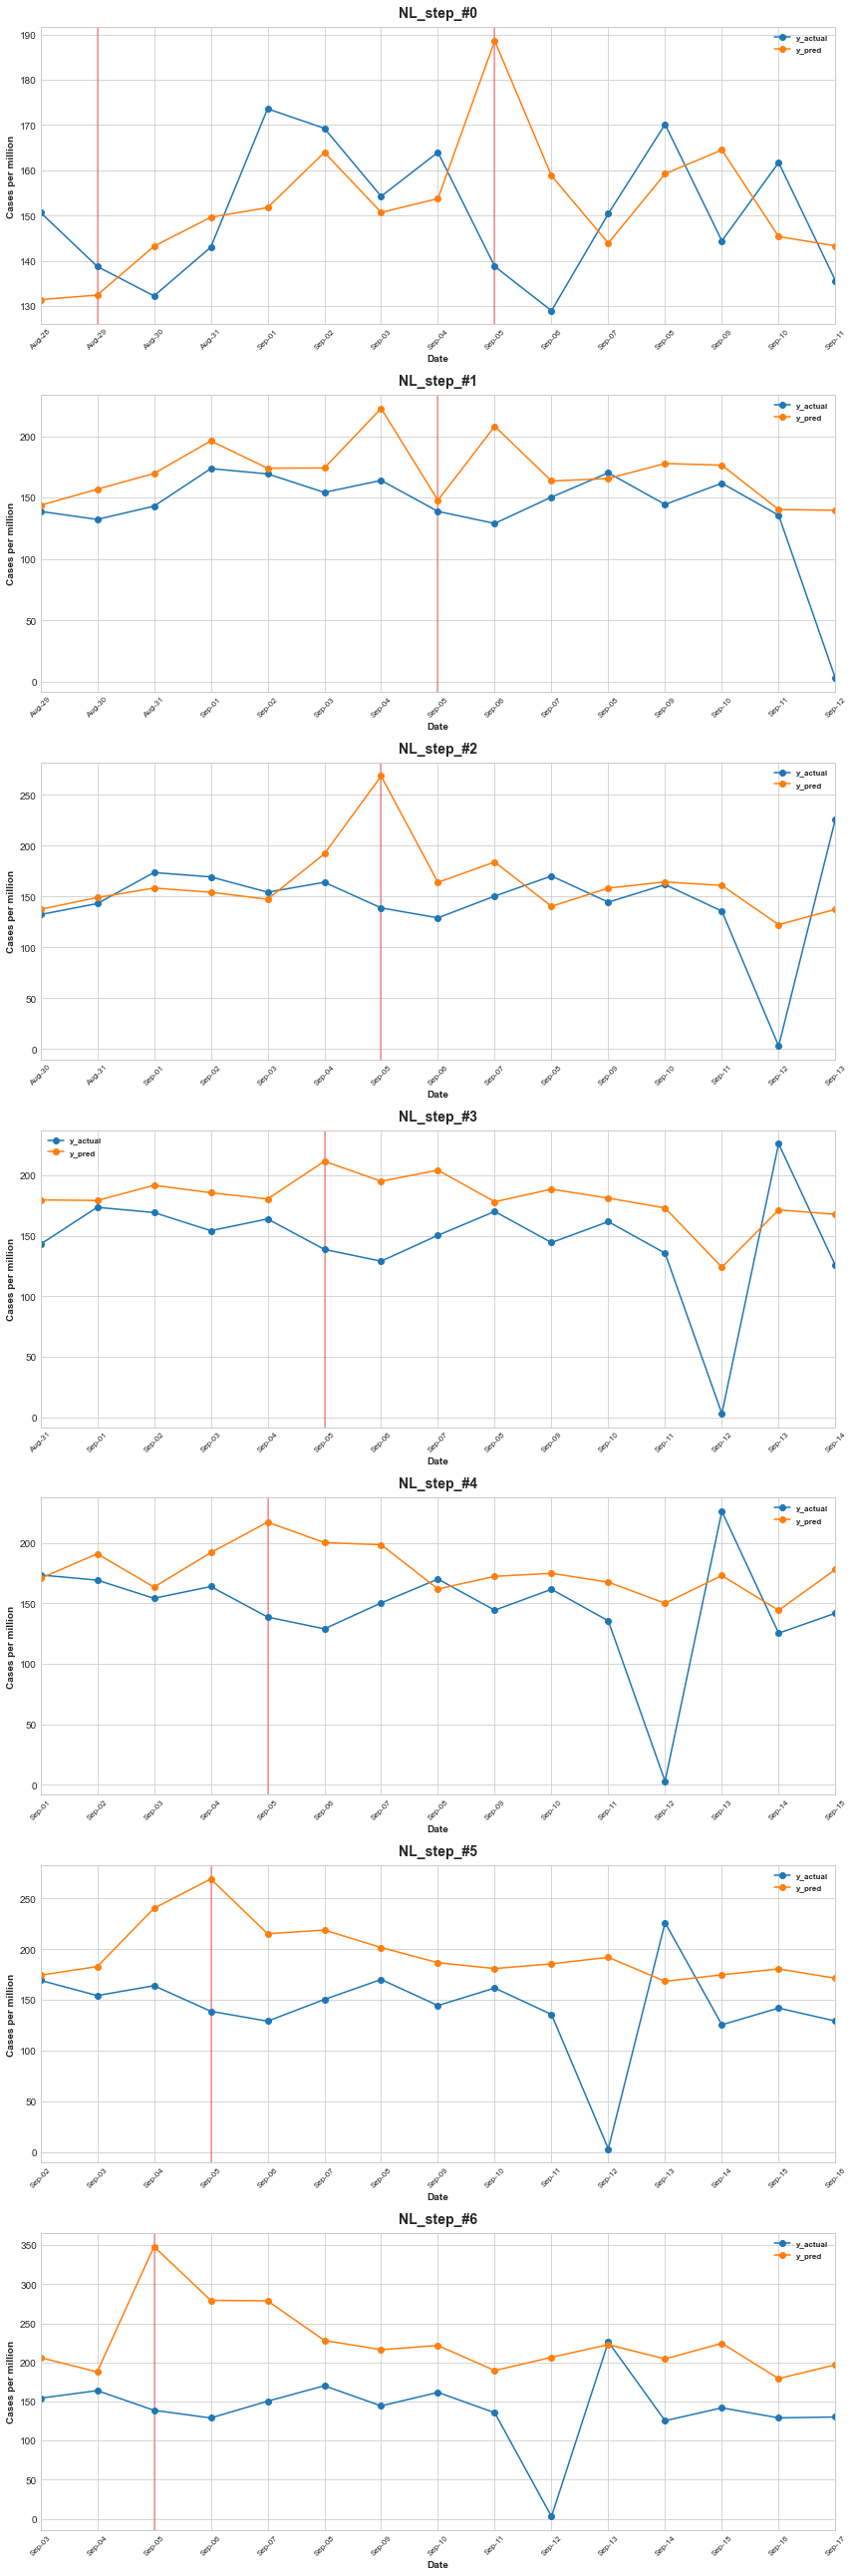

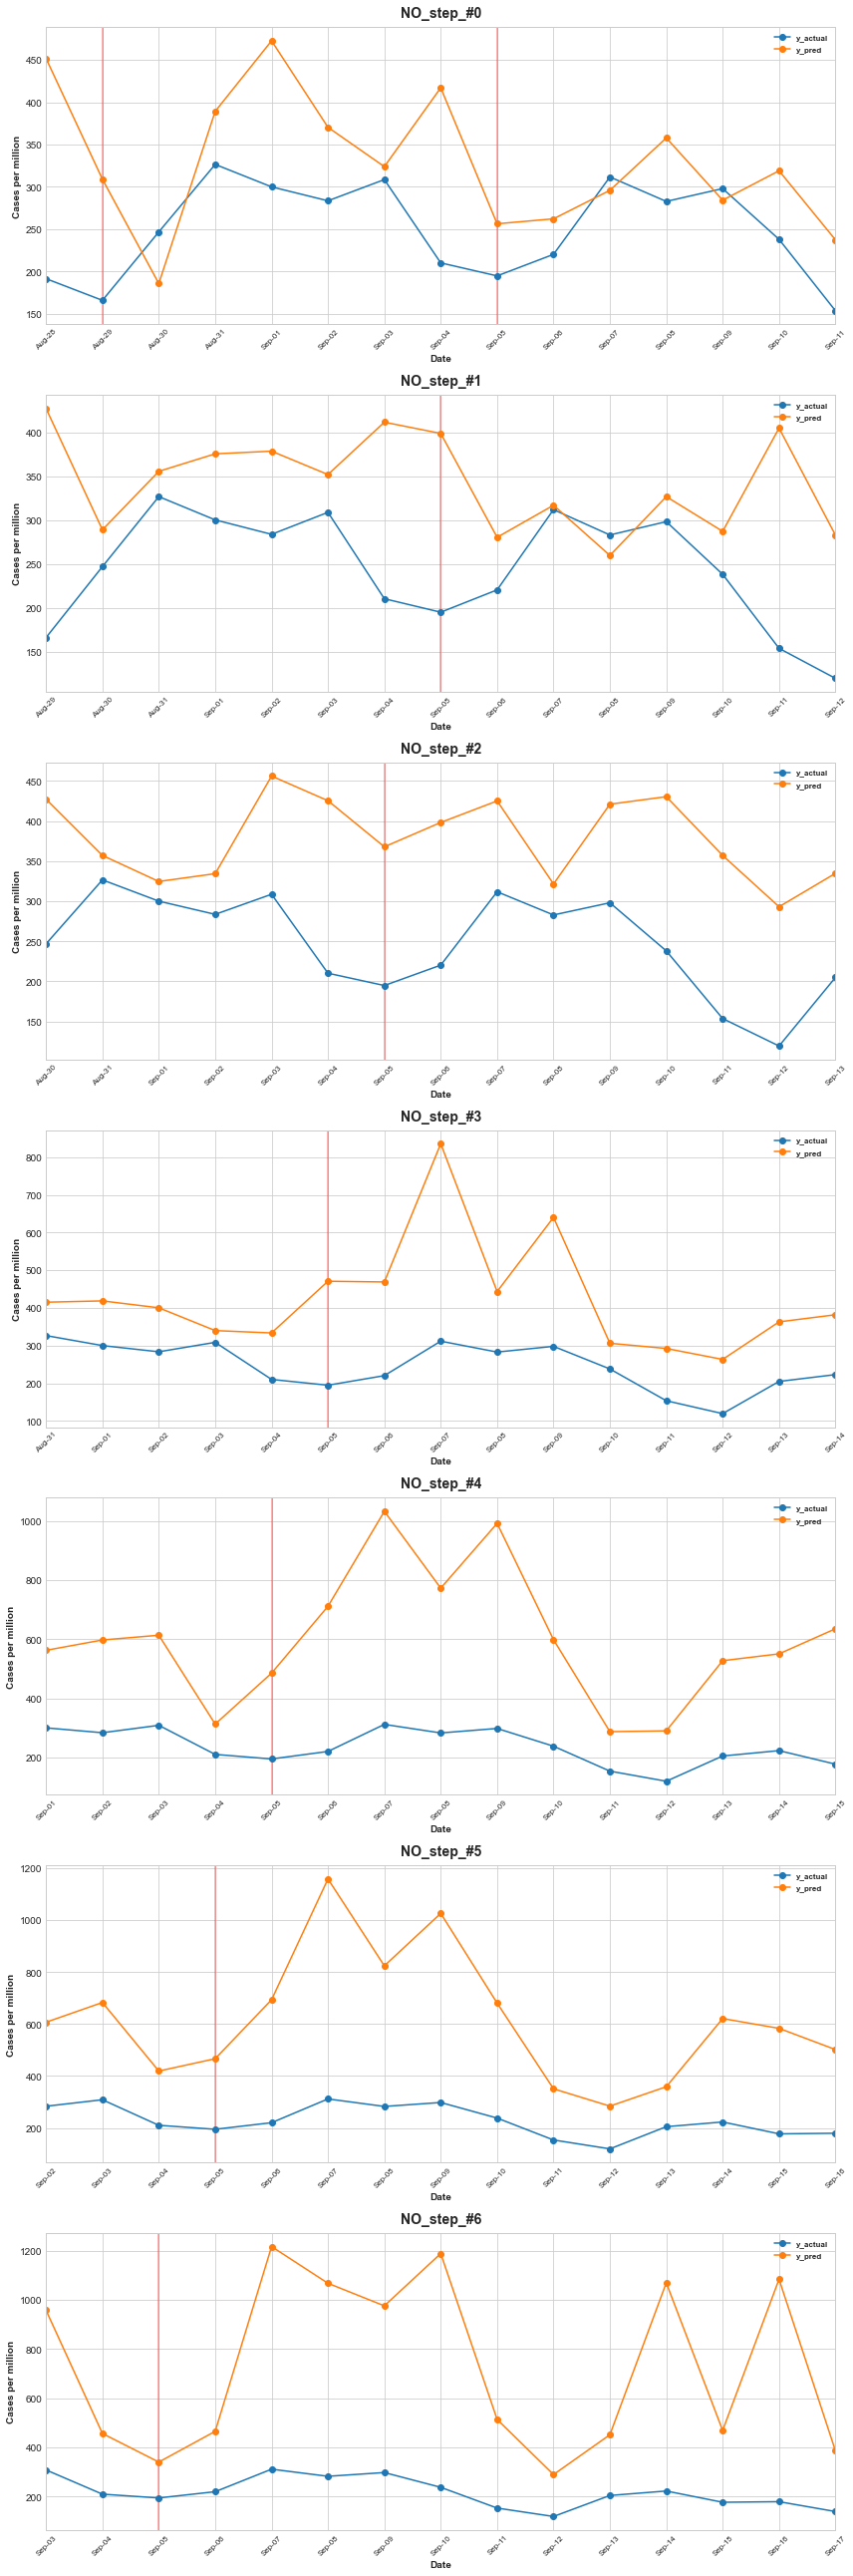

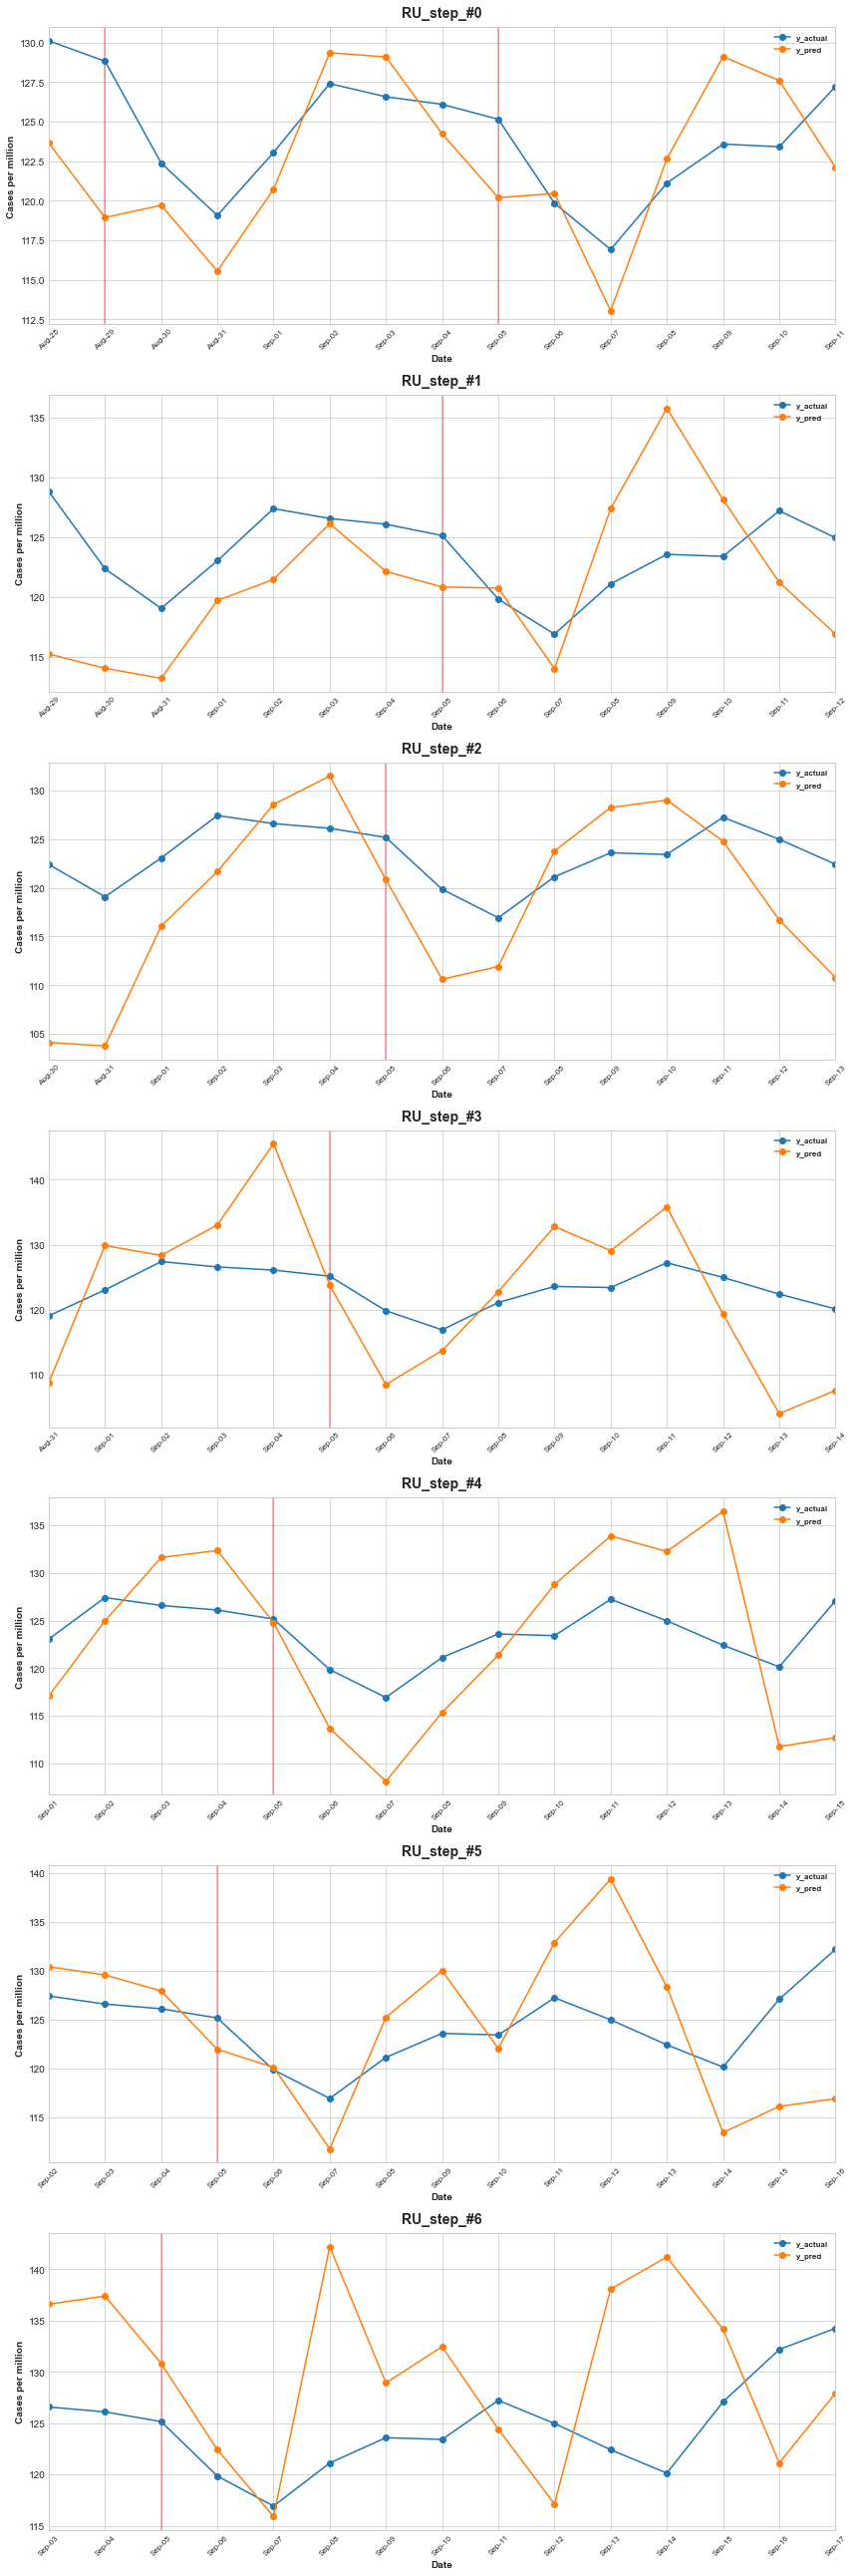

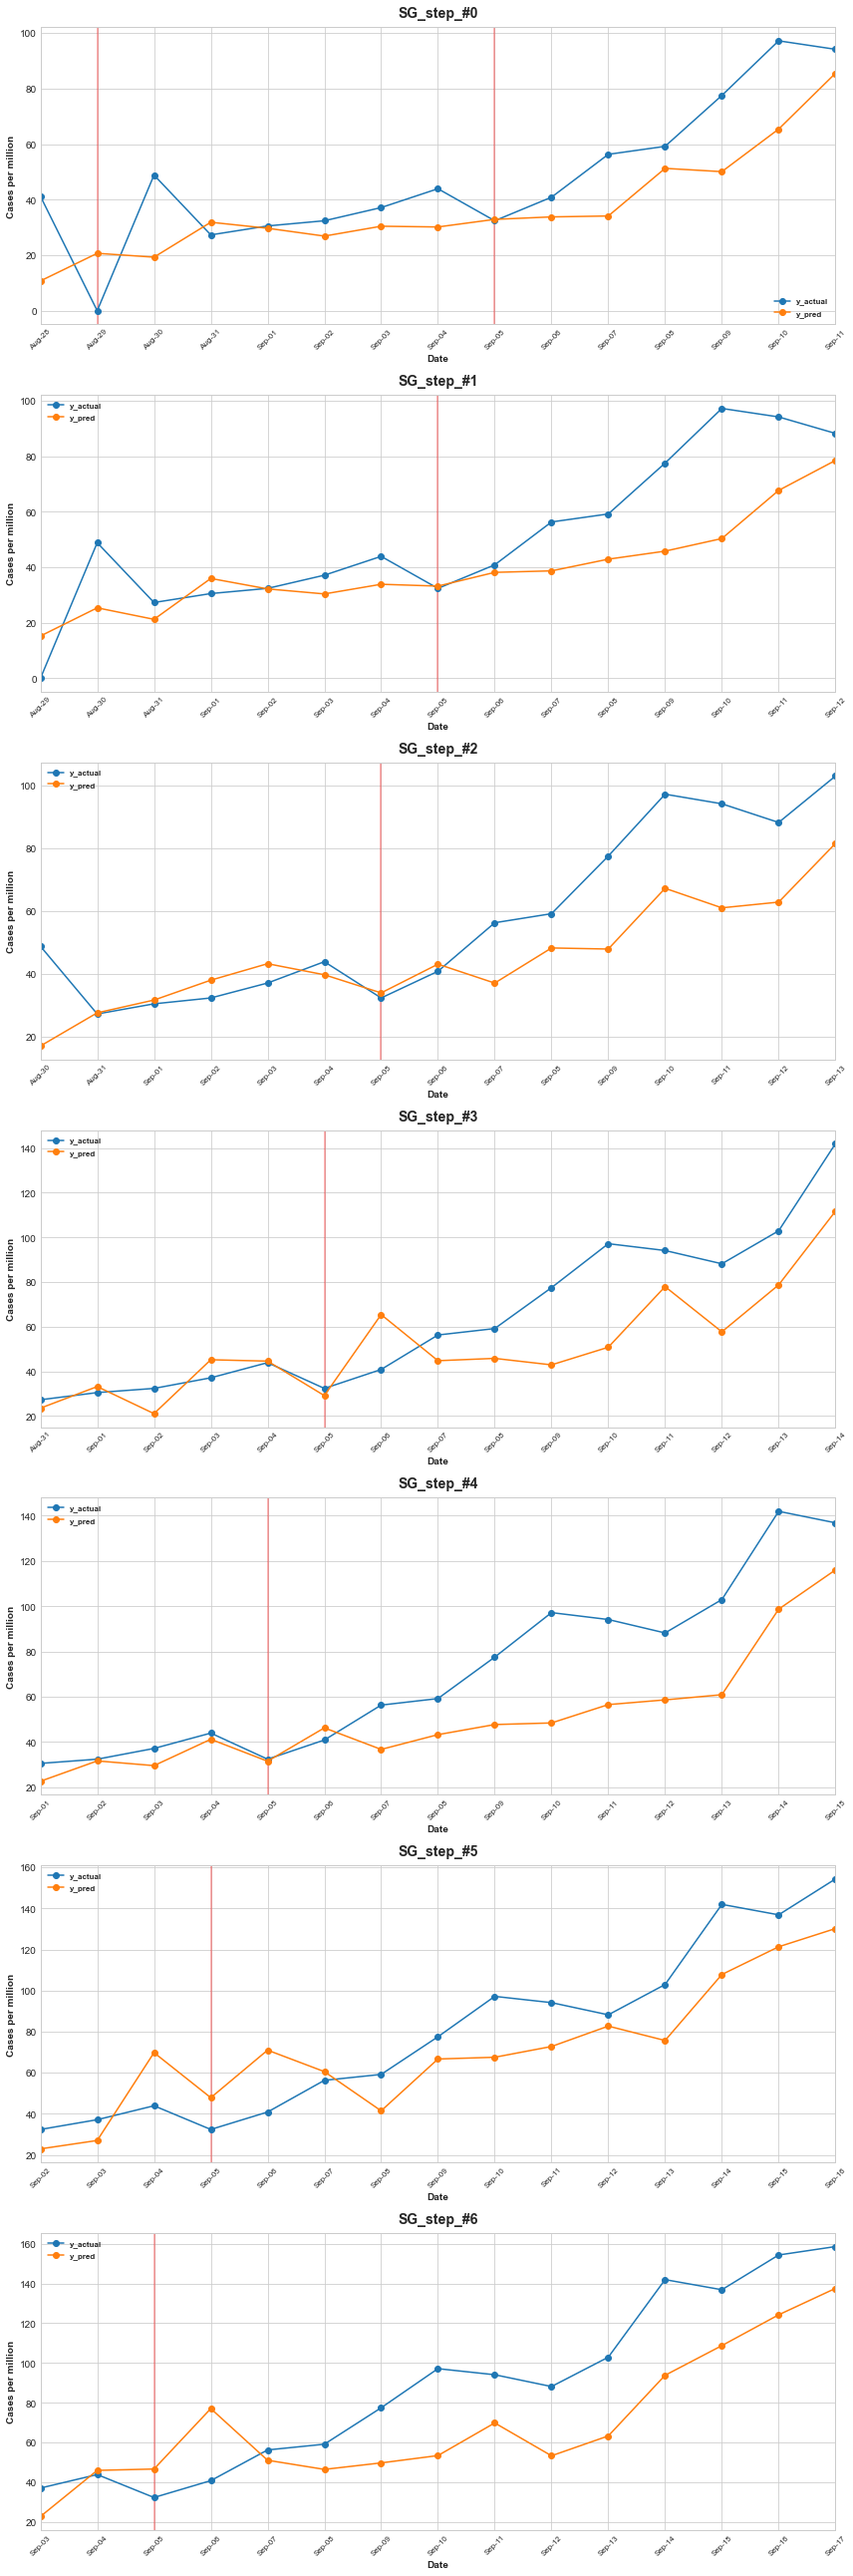

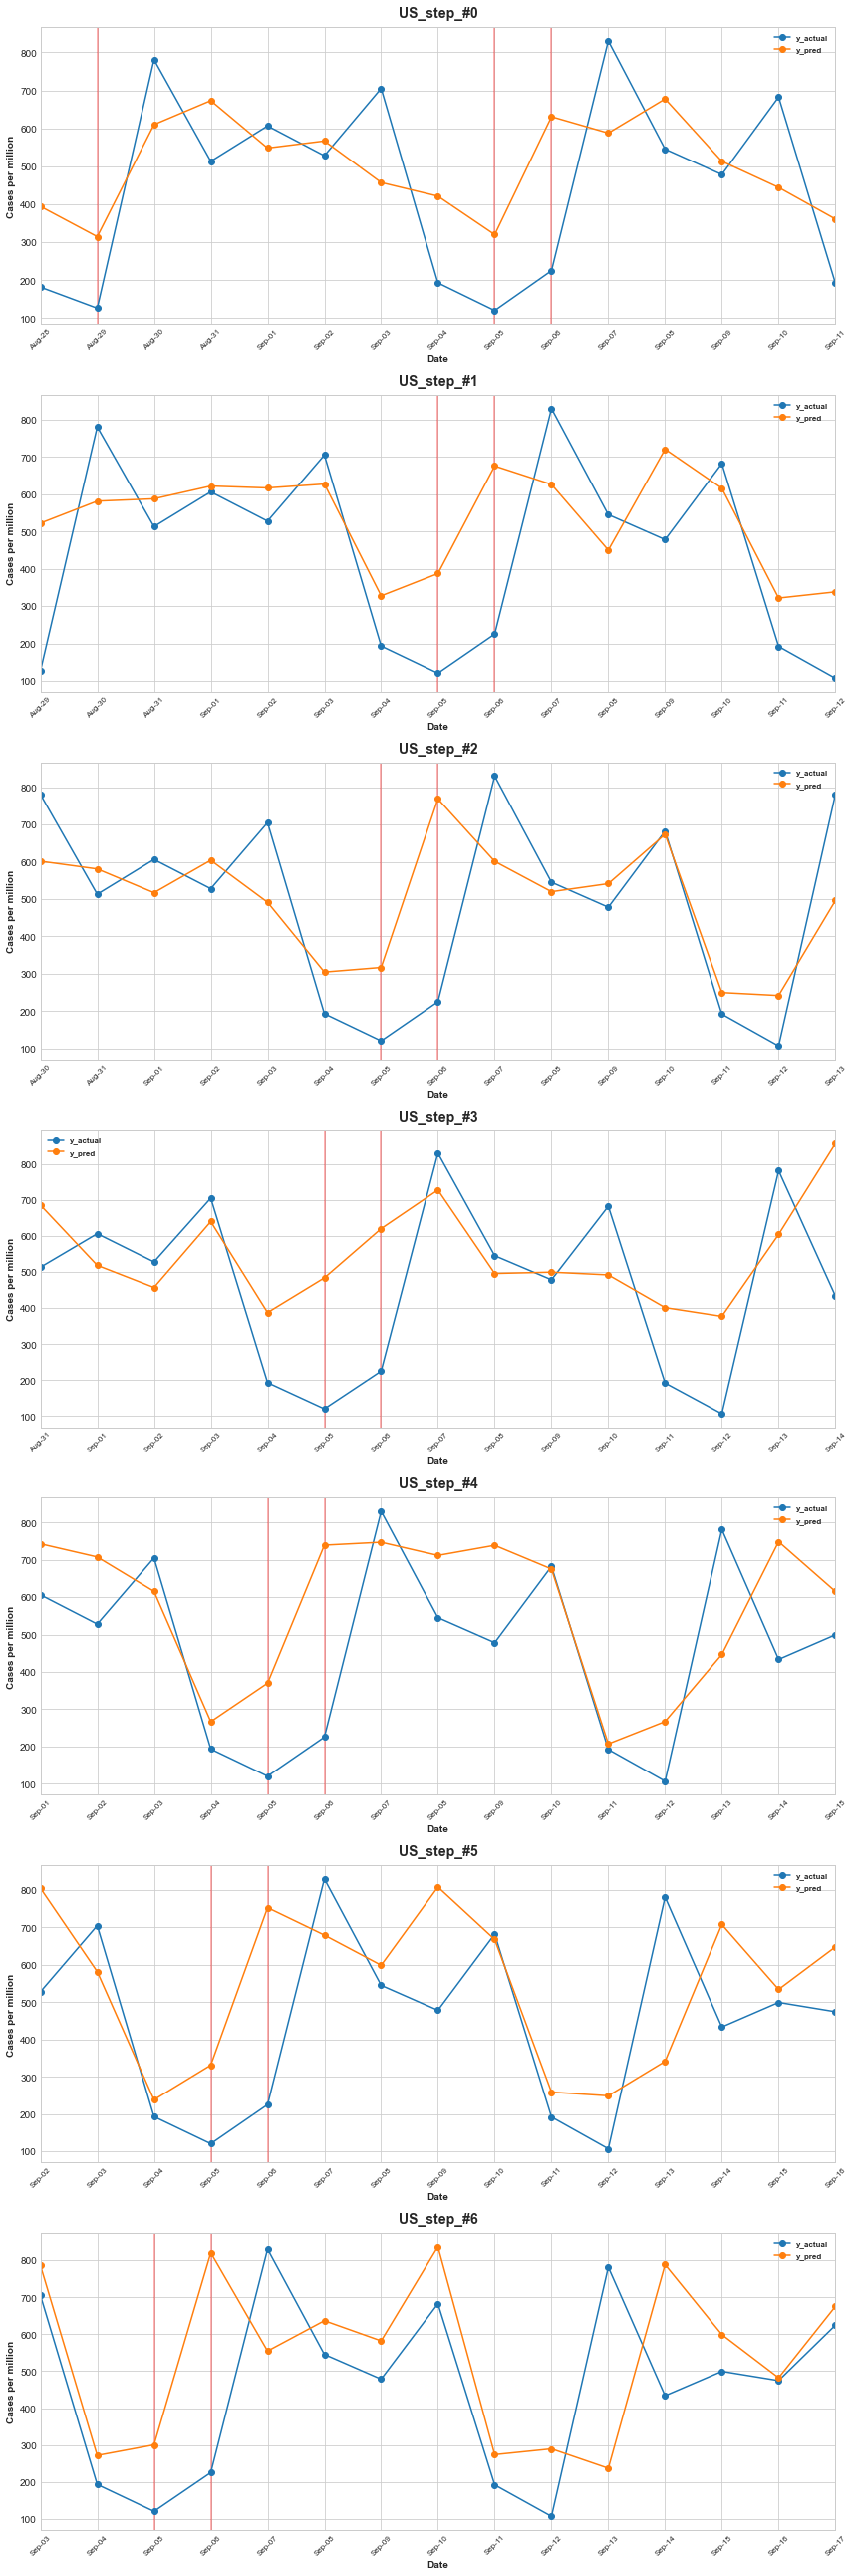

In [358]:
plot_test_set(rez_xgbr_7d_test, dict_country, 'test', n_steps_out=7)

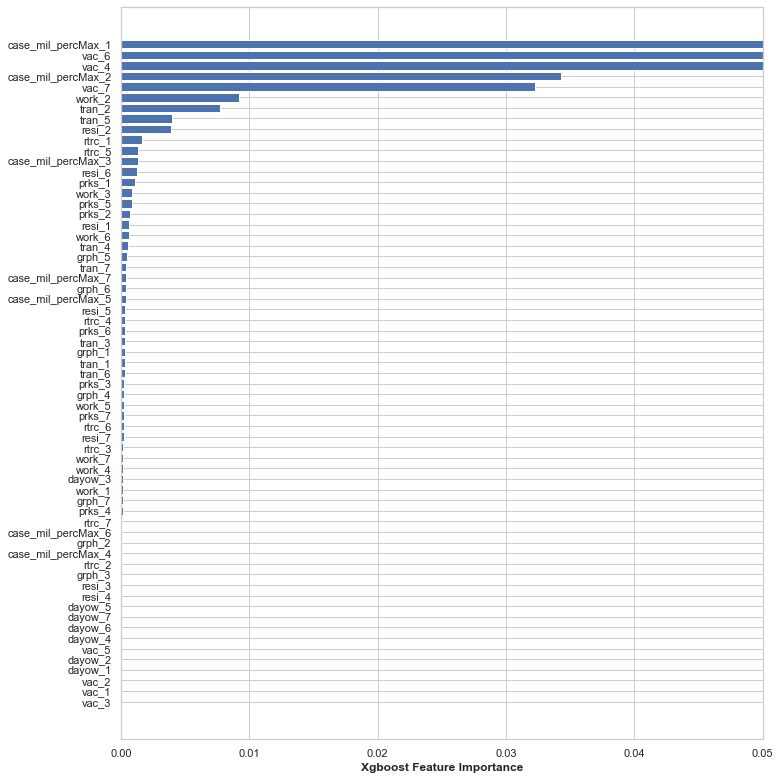

In [65]:
#modelRF.feature_importances_[:-7]
df_xg_rez = pd.DataFrame({'date':df_feat_targ.index[-n_test:], 'y': [float(i) for i in y], 'yhat': yhat})
df_xg_rez.set_index('date',inplace=True)
# feature names used to fit the model 
feat_name = df_feat_targ.columns[:-1]
# sort features based on feature importances
sorted_idx = modelXG.feature_importances_.argsort()
# plot feature importance
plt.rc("figure", autolayout=True, figsize=(11, 11))
plt.barh(feat_name[sorted_idx], modelXG.feature_importances_[sorted_idx])
plt.xlabel("Xgboost Feature Importance")
plt.xlim([0, 0.05])
plt.show()

In [66]:
# save the model
filePath_pickle = Path('/Users/parkj/Documents/pyDat/pyDatCode/covid19/covid19_case_timeSeries_modelXG_7day.pkl')
pickle_out = open(filePath_pickle, 'wb') # open to write binary
pickle.dump(rez_XGBoost_dict, pickle_out)
pickle_out.close()

In [68]:
# load the model
filePath_pickle = Path('/Users/parkj/Documents/pyDat/pyDatCode/covid19/covid19_case_timeSeries_modelXG_7day.pkl')
pickle_in = open(filePath_pickle, 'rb') # open to read binary
modelXG_7day = pickle.load(pickle_in)
pickle_in.close()

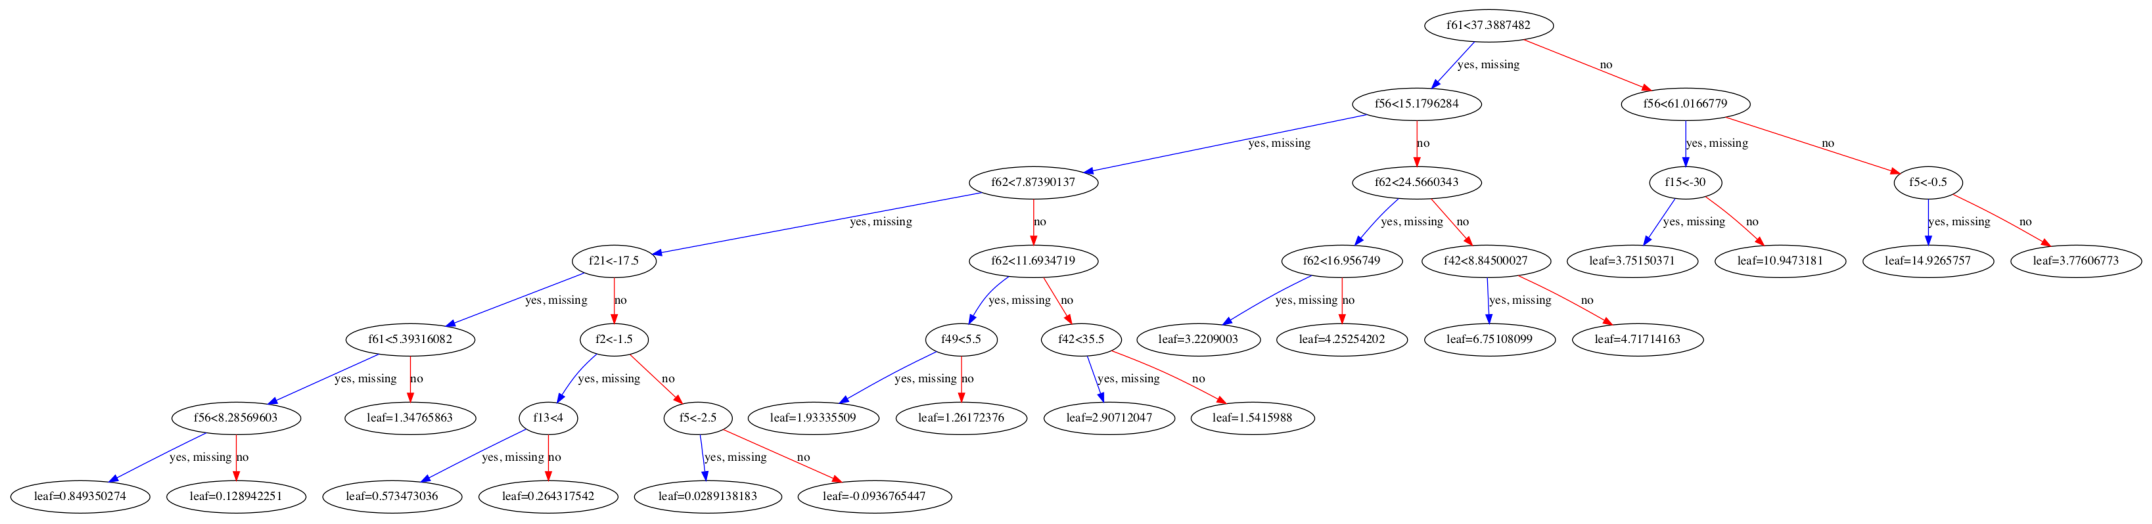

In [80]:
# visualize a decision tree of the XGBoost regressor using its own plot_tree function
fig, ax = plt.subplots(figsize=(30, 30))
plot_tree(modelXG_7day['case_mil_percMax_0']['model'], num_trees=1, ax=ax)
plt.show()